<a id='summary'></a>
# Reading and evaluating everything

## Summary
* [Loading data](#data)
    * [Trips_by_hour_odm](#trips_by_hour_odm)
    * [EGT raw](#egtraw)
    * [EGT filtered](#egt)
    * [Activity chains](#loading_activity_chains)
    * [Synthpop](#synthpop)
        * [Creating synthpop_trips](#synthpop_trips)
    * [GIS](#gis)
    * [OD matrices from mobile](#orange)
    * [Eqasim](#eqasim)
        * [Snapping gdf to our GIS](#snap)
        * [Home GDF](#homegdf)
        * [resident_trips_df](#resident_trips_df)


* [Comparing socio-eco profiles](#socioeco)


* [Comparing zone populations](#zonepop)


* [Counting agendas that start and don't start at home](#homestart)



* [Counting static agendas](#static)
    * [In Eqasim](#staticeqasim)
    * [In our synthpop](#staticsynthpop)


* [Computing OD matrix of pop](#od)
    * [odeqasim](#odeqasim)
    * [odsynthpop](#odsynthpop)
    * [Comparing P(D | O, T)](#odcomppd)
    * [Viz of P(D | O, T)](#odcomppdviz)
    * [Comparing P(O, D | T)](#odcomppod)
    * [Viz of P(O, D | T)](#odcomppodviz)
    * [Comparing P(O | D, T)](#odcomppo)
    * [Generating paper table](#Paper_table)
    * [Investigating the impact of additive noise on KL-divergence](#eps_sensitivity)


* [Recreating official commute matrix](#recreating_true_commute)
    * [Synthpop commute](#Synthpop_commute)
    * [Eqasim commute](#eqasim_commute)
    

* [Distribution of lengths of trips](#lengths)


* [Comparing number of trips per timestep](#profiles)


* [Comparing agenda popularity](#agenda_pop)
    * [Agenda popularity in synthpop](#synthpopagendapop)
    * [Agenda popularity in HTS](#htsagendapop)
    * [Agenda popularity in eqasim](#eqasimagendapop)
    * [Gini agenda popularity](#giniagendapop)
    * [Plotting agenda popularity disparity](#plotagendapop)
    

* [Comparing to official results](#reports)


* [Recreating EGT results](#egt_res)
    * [Radial trips](#radial_trips)
        * [Socio eco comp of radial trips](#socioeco_comp_radial_trips)
    * [Commute distance wrt occupation](#commute_wrt_profession)
    * [Recreating not-commute trips](#recreating_not_commute)
    

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import os

tqdm.pandas()

from utils.chrono import Chrono
chrono_notebook = Chrono('Launching notebook...')

from utils.redistribute_hourly import redistribute_hourly



with open('config.json', 'r') as config_path:
    config = json.load(config_path)

11:44:05	Launching notebook...


In [2]:
fac_font = 2.5
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10*fac_font,
    "font.size": 10*fac_font,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8*fac_font,
    "xtick.labelsize": 8*fac_font,
    "ytick.labelsize": 8*fac_font
}
plt.rcParams.update(tex_fonts)

In [3]:
color_dict = {
    'census' : (0,0,0),
    'synthpop' : (182/255,0/255,74/255),
    'synthpop_pre_ipu' : (88/255, 35/255, 128/255),
    'EMD' : (170/255, 204/255, 0/255),
    #'HTS' : (0/255, 158/255, 15/255),  # Green Wong for colorblindsafe palette 
    'HTS' : (240/255, 228/255, 66/255),  # Green Wong for colorblindsafe palette 
    'odm' : (241/255, 154/255, 0/255),
    'eqasim' : (48/255, 190/255, 242/255)
}


<a id='data'></a>
# Loading data

<a id='trips_by_hour_odm'></a>
## trips_by_hour_odm
* [Back to summary](#summary)

In [4]:
# From un-anonymised OD-matrices
trips_by_hour_odm_path = os.path.join(config['outdata_dir']['path'], 
                                      config['outdata_dir']['trips_by_hour_filename'])
trips_by_hour_odm = pd.read_csv(trips_by_hour_odm_path)
print(trips_by_hour_odm['vol'].sum())
timesteps = trips_by_hour_odm['t'].values
timesteps

1787219.0412896487


array([ 0,  2,  5,  7,  8,  9, 10, 12, 14, 16, 17, 18, 19, 20, 22])

<a id='egtraw'></a>
## EGT raw
* raw version, closer to what eqasim uses
* [Back to summary](#summary)

In [5]:
from shapely import wkt

xmin, ymin, xmax, ymax = 3910400, 2516300, 3936000, 2541900
study_zone_wkt = "POLYGON(({0} {1}, {0} {3}, {2} {3}, {2} {1}, {0} {1}))".format(xmin,ymin,xmax,ymax)
study_zone = wkt.loads(study_zone_wkt)

c = Chrono('Loading GIS...')
zf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_gis_filename'])
zf = gpd.read_file(zf_path).to_crs('epsg:3035')

zf['is_point'] = zf.geometry.to_wkt().str.startswith('POINT')

c.write('Intersecting with study zone...')
zf = zf.drop(zf[~zf['geometry'].intersects(study_zone)].index)
# buffering because weird poly make intersection crash  # NOT buffering points.
zf.loc[~zf['is_point'], 'geometry'] = zf[~zf['is_point']]['geometry'].buffer(1).intersection(study_zone)


c.tprint('Reporting points zf to their containing polygon zf...')
zf_points = zf[zf['is_point']]
zf = zf.drop(zf.index[zf['is_point']])
zf_points['x'] = zf_points['geometry'].x
zf_points['y'] = zf_points['geometry'].y
zf_points = zf_points.drop(zf_points[~zf_points['geometry'].within(study_zone)].index)

zf_points['cart'] = 1
zf['cart'] = 1
cart = zf_points.merge(zf[['ZF2015_Nouveau_codage', 'geometry', 'cart']], on='cart', suffixes=('','_poly'))
cart = cart.drop(cart[~cart['geometry'].within(cart['geometry_poly'])].index)
zf_replace_dict = {idzfpoint: idzf for idzfpoint, idzf in cart[['ZF2015_Nouveau_codage',
                                                                'ZF2015_Nouveau_codage_poly']].values}

c.write('{} zones fines'.format(len(zf)))

c.write('Loading households...')
men_faf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_men_faf_filename'])
men_faf = pd.read_csv(men_faf_path, sep=';',dtype={'ZFM':str, 'ECH':str})

men_tel_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_men_tel_filename'])
men_tel = pd.read_csv(men_tel_path, sep=';',dtype={'ZFM':str, 'ECH':str})

men_egt_raw = pd.concat([men_faf,men_tel])
men_egt_raw['id_men'] = men_egt_raw['ZFM'] + men_egt_raw['ECH']
c.write('{} rows ({} in faf - {} in tel)'.format(len(men_egt_raw), len(men_faf), len(men_tel)))

c.write('Loading persons...')
per_faf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_per_faf_filename'])
per_faf = pd.read_csv(per_faf_path, sep=';', dtype={'ZFP':str, 'ECH':str,'PER':str})

per_tel_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_per_tel_filename'])
per_tel = pd.read_csv(per_tel_path, sep=';', dtype={'ZFP':str, 'ECH':str,'PER':str})

per_egt_raw = pd.concat([per_faf, per_tel])
per_egt_raw['id_men'] = per_egt_raw['ZFP'] + per_egt_raw['ECH']
per_egt_raw['id_per'] = per_egt_raw['id_men'] + per_egt_raw['PER']
per_egt_raw = per_egt_raw.drop(['ECH'], axis=1)
c.write('{} rows ({} in faf - {} in tel)'.format(len(per_egt_raw), len(per_faf), len(per_tel)))

c.write('Loading travels...')
depl_faf_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_depl_faf_filename'])
depl_faf = pd.read_csv(depl_faf_path, sep=';', dtype={'D4':str, 'D8':str, 'ZFD':str, 'ECH':str,'PER':str, 'NDEP':str})

depl_tel_path = os.path.join(config['data_dir']['path'], config['data_dir']['HTS_depl_tel_filename'])
depl_tel = pd.read_csv(depl_tel_path, sep=';', dtype={'D4':str, 'D8':str, 'ZFD':str, 'ECH':str,'PER':str, 'NDEP':str})

depl_egt_raw = pd.concat([depl_faf,depl_tel])
depl_egt_raw['id_per'] = depl_egt_raw['ZFD'] + depl_egt_raw['ECH'] + depl_egt_raw['PER']
depl_egt_raw['id_dep'] = depl_egt_raw['id_per'] + depl_egt_raw['NDEP']
depl_egt_raw = depl_egt_raw.merge(per_egt_raw[['COE1', 'id_per']], on='id_per')
depl_egt_raw = depl_egt_raw.drop(['ECH', 'PER'], axis=1)
c.write('{} rows ({} in faf - {} in tel)'.format(len(depl_egt_raw), len(depl_faf), len(depl_tel)))

c.write('Reporting point ZF...')
men_egt_raw['ZFM']  = men_egt_raw['ZFM'].replace(zf_replace_dict)
per_egt_raw['ZFP']  = per_egt_raw['ZFP'].replace(zf_replace_dict)
depl_egt_raw['ZFD'] = depl_egt_raw['ZFD'].replace(zf_replace_dict)
c.done()

11:44:05	Loading GIS...
00:00:01	Intersecting with study zone...
00:00:01	Reporting points zf to their containing polygon zf...
00:00:01	591 zones fines
00:00:01	Loading households...
00:00:01	16361 rows (9746 in faf - 6615 in tel)
00:00:01	Loading persons...
00:00:01	36564 rows (21061 in faf - 15503 in tel)
00:00:01	Loading travels...
00:00:02	99585 rows (68153 in faf - 31432 in tel)
00:00:02	Reporting point ZF...
00:00:02	Work complete !


<a id='egt'></a>
## EGT filtered
* Filtered version
* [Back to summary](#summary)

In [6]:
zf_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_gis_filtered_filename'])
zf = gpd.read_file(zf_path, dtype={'ZF2015_Nouveau_codage':int})
zf['ZF2015_Nouveau_codage'] = zf['ZF2015_Nouveau_codage'].astype(int)

In [7]:
egt_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_filtered_filename'])
egt = pd.read_csv(egt_path)
print('{} rows, {:.0f} persons with rescaling'.format(len(egt), egt['scaling_factor_person'].sum()))
egt = egt.merge(zf[['ZF2015_Nouveau_codage']], left_on='zf_home', right_on='ZF2015_Nouveau_codage')
print('After keeping only persons living inside the study zone:')
print('{} rows, {:.0f} persons with rescaling'.format(len(egt), egt['scaling_factor_person'].sum()))


18572 rows, 1369071 persons with rescaling
After keeping only persons living inside the study zone:
18572 rows, 1369071 persons with rescaling


In [8]:
activity_chain_path = os.path.join(config['outdata_dir']['path'], 
                                   config['outdata_dir']['activity_chains_filename'])
print('Loading activity chains from {}'.format(activity_chain_path))
activity_chains = pd.read_csv(activity_chain_path)
activity_chains['chain_len'] = activity_chains['chain_len'].astype(int)
max_chain_len = activity_chains['chain_len'].max()

for ts in timesteps:
    activity_chains['ts_{}'.format(ts)] = 0
    
for i in range(1, max_chain_len+1):
    for ts in timesteps:
        activity_chains.loc[activity_chains['dep_{}_time'.format(i)]==ts, 'ts_{}'.format(ts)] += 1
        
mod_trips_cols = ['ts_{}'.format(ts) for ts in timesteps]

per_cols = config['per_cols_rescaling']  # Define the socio-eco vars we will consider in the rescaling


Loading activity chains from /Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/activity_chains.csv


In [9]:

# egt_dummies=egt.dropna()[['id_per'] + per_cols].astype(int)
# egt_dummies['mod_socio_eco'] = egt_dummies[per_cols].apply(lambda r: str(tuple(r)), axis=1)
# mod_socio_eco_cols = list(egt_dummies['mod_socio_eco'].unique())
# egt_dummies = pd.get_dummies(egt_dummies, 'mod_socio_eco')
# 
# print(len(egt_dummies))
# egt_dummies = egt_dummies.merge(activity_chains, on='id_per')
# print(len(egt_dummies))
# egt_dummies = egt_dummies.rename(columns={'mod_socio_eco_{}'.format(col):col for col in mod_socio_eco_cols})
# egt_dummies = egt_dummies[['id_agenda'] + mod_socio_eco_cols + mod_trips_cols + ['chain_len']]
# 

In [10]:
depl_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_depl_filtered_filename'])
depl_ori = pd.read_csv(depl_path, dtype={'D4':str, 'D8':str})

depl_ori = depl_ori.merge(egt[['id_per', 'scaling_factor_person']], on='id_per')
print('Keeping only trips of persons living inside the study zone:')
print('{} rows, {:.0f} trips with rescaling'.format(len(depl_ori), depl_ori['scaling_factor_person'].sum()))

depl_ori = depl_ori.merge(zf[['ZF2015_Nouveau_codage']], left_on='D7', right_on='ZF2015_Nouveau_codage', how='left')

print('Among which {} activities ({:.0f} with rescaling) are outside the study zone'.format(
        depl_ori['ZF2015_Nouveau_codage'].isna().sum(),
        depl_ori[depl_ori['ZF2015_Nouveau_codage'].isna()]['scaling_factor_person'].sum(),
))

Keeping only trips of persons living inside the study zone:
53486 rows, 3996443 trips with rescaling
Among which 0 activities (0 with rescaling) are outside the study zone


<a id='loading_activity_chains'></a>
## Loading activity chains
* [Back to summary](#summary)

In [11]:
activity_chain_path = '/Users/benoit/Desktop/Pro/210526-fusion/outdata/synthpop/activity_chains.csv'
activity_chains = pd.read_csv(activity_chain_path)
activity_chains.head()

,id_per,dep_0_motif,dep_0_zone,outsider,chain_len,zf_home,scaling_factor_person,dep_1_mode,dep_1_motif,dep_1_time,...,dep_6_distbin,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute
0,1.010011e+09,0.0,101001.0,0.0,2.0,101001.0,54.14797,3.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,True,True
1,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,29.75996,3.0,4.0,10.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,False,False
2,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,51.85581,3.0,1.0,8.0,...,NaN,NaN,NaN,NaN,NaN,1.0,3.0,True,False,True
3,1.010018e+08,0.0,101001.0,0.0,2.0,101001.0,53.59816,3.0,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,True,True
4,1.010021e+09,0.0,101002.0,0.0,4.0,101002.0,50.09030,3.0,3.0,10.0,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,False,False,False


In [12]:
egt['id_per'] = egt['id_per'].astype(float)
egt_with_activity_chains = egt.merge(activity_chains.drop(columns=['scaling_factor_person']), on='id_per')


<a id='synthpop'></a>
## Our synthpop
* [Back to summary](#summary)

In [13]:
gis_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['gis_map_filename'])
synthpop_paths = {
# forward, naive markov:
   'v1':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev1.csv'),
# forward, home return:
#   'v2':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev2.csv'),
# forward, home, study & work return:
   'v3':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev3.csv'),
# forward, home, study & work return, by mode:
#   'v4':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev4.csv'),
# forward, home, study & work return, by mode and dist bin:
#   'v5':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev5.csv'),
# forward, home, study & work return, by mode and dist bin:
#   'v45':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev45.csv'),
    
# MCMC:
#   'v6':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev6.csv'),
# MCMC with linked states:
#   'v7':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev7.csv'),
# MCMC with linked states, no transport mode:
   'v8':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev8.csv'),
# like v8 but with root hack like in v9h5
#   'v8h':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev8h.csv')
# like v8h but using vol of flows instead of proba_d, since they are potentials anyway
   'v8h2':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev8h2.csv'),
# # MCMC with linked states, by distance bin instead of transport mode:
#   'v9':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev9.csv'),
# # MCMC with linked states, by distance bin AND transport mode:
# #   'v10':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev10.csv',
#   # sqrt hack, counting home states around current state and all state of the same linkset    
#    'v9h':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9h.csv',
# # same as v9h but if a state is alone in its linkset it can count any linkset as fixed neighbors, not only home
#    'v9hp':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9hp.csv',
# # separating roots wrt linkset
#    'v9h2':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9h2.csv',
# # separating roots wrt linkset, using vol of flows instead of proba_d, since they are potentials anyway
#    'v9h3':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9h3.csv',
# # separating roots wrt linkset, using vol of flows instead of proba_d, better handling of linksets
#    'v9h4':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9h4.csv',
# # like v9h4 but using proba_d instead of vol
#    'v9h5':'../../outdata/synthpop/synthpop_statmatch_rescaleipu_spatializev9h5.csv',

# # like v9h5 but counting twice the double factors when we have diamond patterns. Also distance is computed from centroids
   'v9h6':os.path.join(config['outdata_dir']['path'], 'synthpop/synthpop_statmatch_rescaleipu_spatializev9h6.csv')
}

c = Chrono('Loading {} synthpops...'.format(len(synthpop_paths)))
synthpops = {}
for k,synthpop_path in synthpop_paths.items():
    c.write('{}...'.format(k))
    synthpop = pd.read_csv(synthpop_path)
    
    # Arranging modalities to be compatible with the other pops...
    synthpop['occupation'] = synthpop['occupation'].replace({8:0})
    
    synthpops[k] = synthpop

c.done()

11:44:09	Loading 5 synthpops...
00:00:00	v1...
00:00:10	v3...
00:00:19	v8...
00:00:26	v8h2...
00:00:37	v9h6...
00:00:47	Work complete !


<a id='synthpop_trips'></a>
### Creating `synthpop_trips`
* [Back to summary](#summary)

In [14]:
synthpop_trips_dict = {}

for k, synthpop in synthpops.items():
    max_chain_len = synthpop['chain_len'].max()
    synthpop_trips = pd.DataFrame()
    for i in tqdm(range(1, max_chain_len+1)):
        trips_i = synthpop.loc[i<=synthpop['chain_len']][['agent_id', 
                                                'dep_{}_zone'.format(i-1), 
                                                'dep_{}_zone'.format(i),
                                                'dep_{}_time'.format(i),
                                                'dep_{}_motif'.format(i-1), 
                                                'dep_{}_motif'.format(i), 
                                                'dep_{}_mode'.format(i),
                                               ]].rename(columns={
            'agent_id' : 'person_id',
            'dep_{}_zone'.format(i-1):'o',
            'dep_{}_zone'.format(i):'d',
            'dep_{}_time'.format(i):'t',
            'dep_{}_motif'.format(i-1):'o_purpose',
            'dep_{}_motif'.format(i):'d_purpose',
            'dep_{}_mode'.format(i):'mode',
        })
        synthpop_trips = pd.concat([synthpop_trips, trips_i])
    synthpop_trips_dict[k] = synthpop_trips

100%|███████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s]


<a id='gis'></a>
## Census gis
* [Back to summary](#summary)

In [15]:

gis_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['gis_map_filename'])


iris_commune = gpd.read_file(gis_path)
iris_commune = iris_commune.set_crs('epsg:3035')

iris_commune['iris_or_commune'] = iris_commune['iris_or_commune'].astype(int)
iris_commune['x'] = iris_commune['x'].astype(float)
iris_commune['y'] = iris_commune['y'].astype(float)

iris_commune.head()

,iris_or_commune,frac_area,is_iris,commune,x,y,nearest_neighbor_0,nearest_neighbor_1,nearest_neighbor_2,nearest_neighbor_3,...,nearest_neighbor_12,nearest_neighbor_13,nearest_neighbor_14,nearest_neighbor_15,nearest_neighbor_16,nearest_neighbor_17,nearest_neighbor_18,nearest_neighbor_19,wkt,geometry
0,1043,1.0,False,01043,3.932173e+06,2.538223e+06,692820201,692820103,692560101,692860101,...,692820601,01249,01276,01424,01262,01418,01049,01376,"POLYGON ((3931567.736276 2535603.293955, 39314...","POLYGON ((3931567.736 2535603.294, 3931455.673..."
1,1049,0.903,False,01049,3.934408e+06,2.538726e+06,692820103,692820201,01275,692750111,...,692820601,692790101,01424,01376,01418,01276,01043,01262,"POLYGON ((3931819.418597 2541777.410918, 39318...","POLYGON ((3931819.419 2541777.411, 3931843.795..."
2,1249,0.901,False,01249,3.927977e+06,2.538779e+06,692860102,69292,692860501,692860201,...,692860302,01043,692860303,692860304,01424,692860101,01376,01275,"POLYGON ((3930627.132465 2534580.112867, 39305...","POLYGON ((3930627.132 2534580.113, 3930588.941..."
3,1262,0.161,False,01262,3.934404e+06,2.540983e+06,692820201,692820204,692820104,692860101,...,692790101,01249,01418,01276,01376,01424,01043,01049,"POLYGON ((3931728.80375 2541776.576776, 393168...","POLYGON ((3931728.804 2541776.577, 3931683.836..."
4,1275,1.0,False,01275,3.926872e+06,2.536284e+06,692560202,01376,692860501,692560302,...,01249,692860401,692860301,692560101,692860302,692860101,692860304,692860303,"POLYGON ((3926169.735135 2534938.132562, 39260...","POLYGON ((3926169.735 2534938.133, 3926094.500..."


<a id='orange'></a>
## Orange OD-matrices
* Not separated by mode
* [Back to summary](#summary)

In [16]:
transition_matrix_path = os.path.join(config['outdata_dir']['path'], 
                                      config['outdata_dir']['transition_matrix_unanon_filename'])
transition_matrix = pd.read_csv(transition_matrix_path)
transition_matrix.head()

,o,d,t,vol,proba_d,proba_o
0,1043,1043,0,9.132230,0.287785,0.205852
1,1043,1043,2,5.813602,0.271967,0.123532
2,1043,1043,5,17.833213,0.105533,0.124070
3,1043,1043,7,54.360548,0.193669,0.187093
4,1043,1043,8,29.113536,0.120248,0.102542


<a id='eqasim'></a>
## Eqasim synthpop
* [Back to summary](#summary)

In [17]:
households_path = os.path.join(config['data_dir']['path'], config['data_dir']['eqasim_households_filename'])
households = pd.read_csv(households_path, sep=';')
print(len(households))
households.head(3)

2061768


,household_id,car_availability,bike_availability,number_of_vehicles,number_of_bikes,income,census_household_id
0,0,all,all,1,2,52.814783,0
1,576,all,all,2,2,1344.299933,170
2,988,all,all,1,2,1221.097529,292


In [18]:
per_path = os.path.join(config['data_dir']['path'], config['data_dir']['eqasim_per_filename'])
per = pd.read_csv(per_path, sep=';')

# Aranging socio-eco class to be compatible with occupation
per['socioprofessional_class'] = per['socioprofessional_class'].replace({8:0, 9:0})

print(len(per))
per.head(3)

4421005


,person_id,household_id,age,employed,sex,socioprofessional_class,has_driving_license,has_pt_subscription,census_person_id,hts_id
0,0,0,68,False,male,7,True,False,0,36220
1,1189,576,62,False,male,7,True,False,360,36220
2,1190,576,57,True,female,4,True,False,361,32276


In [19]:
trips_path = os.path.join(config['data_dir']['path'], config['data_dir']['eqasim_trips_filename'])
trips = pd.read_csv(trips_path, sep=';')
print(len(trips))
trips.head(3)

14995398


,person_id,trip_index,preceding_activity_index,following_activity_index,departure_time,arrival_time,mode,preceding_purpose,following_purpose,is_first,is_last
0,1,0,0,1,45689.0,46889.0,car,home,shop,True,False
1,1,1,1,2,50489.0,51689.0,car,shop,home,False,True
2,2,0,0,1,41840.0,42440.0,car,home,leisure,True,False


In [20]:
activities_path = os.path.join(config['data_dir']['path'], config['data_dir']['eqasim_activities_filename'])
activities = pd.read_csv(activities_path, sep=';')
print(len(activities))
print(activities['purpose'].unique())
activities.head(3)

19416403
['home' 'shop' 'leisure' 'other' 'education' 'work']


,person_id,household_id,activity_index,preceding_trip_index,following_trip_index,purpose,start_time,end_time,is_first,is_last
0,1,1,0,-1,0,home,NaN,45689.0,True,False
1,1,1,1,0,1,shop,46889.0,50489.0,False,False
2,1,1,2,1,-1,home,51689.0,NaN,False,True


<a id='snap'></a>
### Defining `resident_activities_df`
* `activities_gdf` is exactly like `activities` but with an additional col of point geometries
* We are only interested in what we get on the GIS so we snap it
* Also we keep only data related to people living in the study zone
* [Back to summary](#summary)

In [21]:
# ONE-TIME, DO NOT DELETE
# # 01:30:00
#activities_gdf_path = os.path.join(config['data_dir']['path'], config['data_dir']['eqasim_activities_gdf_filename'])

# first_row = 0
# step = 500
# activities_df = pd.DataFrame()
# 
# c=Chrono('Starting...')
# while len(activities_gdf) > 0:
#     activities_gdf = gpd.read_file(activities_gdf_path, rows=slice(first_row, first_row+step))
#     activities_gdf_3035 = activities_gdf.to_crs('epsg:3035')
#     activities_gdf_3035 = activities_gdf_3035.sjoin(iris_commune[['iris_or_commune','geometry']], how='left')
#     activities_df = pd.concat([activities_df, activities_gdf_3035.drop(columns=['geometry', 'index_right'])])
#     first_row += step
#     c.write('{} rows'.format(len(activities_df)))
#     
# activities_df_path = 'lyon_100pct_activities_on_gis.csv'
# c.write('Saving...')
# activities_df.to_csv(activities_df_path, index=False)
# c.done()

<a id='homegdf'></a>
### Home GDF
* [Back to summary](#summary)

In [22]:
c = Chrono('Loading eqasim\'s home gdf...')
homes_gdf_path = os.path.join(config['data_dir']['path'], config['data_dir']['eqasim_home_gdf_filename'])
homes_gdf = gpd.read_file(homes_gdf_path)

c.write('Setting to epsg:3035...')
homes_gdf = homes_gdf.to_crs('epsg:3035')

c.write('Snapping to our GIS...')
homes_gdf = (homes_gdf
            .sjoin(iris_commune[['iris_or_commune','geometry']], how='left')
            .drop(columns=['geometry', 'index_right']))
c.done()

11:46:03	Loading eqasim's home gdf...
00:01:11	Setting to epsg:3035...
00:01:16	Snapping to our GIS...
00:01:21	Work complete !


In [23]:
perxhome = per.merge(homes_gdf, on='household_id')
nb_lost = len(per)-len(perxhome)
print('{} persons out of {} ({:.2%}) don\'t seem to have a household'.format(nb_lost, 
                                                                         len(per),
                                                                         nb_lost/len(per)))

print('{} person of eqasim pop live inside our study zone'.format((~perxhome['iris_or_commune'].isna()).sum()))

397 persons out of 4421005 (0.01%) don't seem to have a household
1380349 person of eqasim pop live inside our study zone


In [24]:
activities_df_path = os.path.join(config['outdata_dir']['path'], 
                                 config['outdata_dir']['eqasim_activities_on_gis_filename'])
activities_df = pd.read_csv(activities_df_path)

resident_activities_df = activities_df.merge(perxhome[~perxhome['iris_or_commune'].isna()][['person_id']], 
                                             on='person_id')
resident_activities_df['hour'] = resident_activities_df['end_time']//3600
resident_activities_df['hour'] = resident_activities_df['hour']%24

print('{} activities of residents out of {} ({:.2g}%) are outside the study zone'.format(
    resident_activities_df['iris_or_commune'].isna().sum(),
    len(resident_activities_df['iris_or_commune']),
    100*resident_activities_df['iris_or_commune'].isna().mean()
))


138696 activities of residents out of 5956010 (2.3%) are outside the study zone


<a id='resident_trips_df'></a>
### Defining `resident_trips_df`
* [Back to summary](#summary)

In [25]:
#fig, ax = plt.subplots(figsize=(8,8))
#trips_gdf.plot(ax=ax)
#iris_commune.boundary.plot(ax=ax)

In [26]:
#c=Chrono('Loading')
#trips_gdf = gpd.read_file(trips_gdf_path)
#c.done()

In [27]:
# # ONE-TIME, DO NOT DELETE
# # 01:30:00
# first_row = 0
# step = 5000
# trips_gdf_path = os.path.join(config['data_dir']['path'], 
#                                 config['data_dir']['eqasim_trips_gdf_filename'])
# 
# 
# import shapely
# def get_odxy(line):
#     return shapely.Point(line.coords[0]), shapely.Point(line.coords[-1])
# 
# trips_df = pd.DataFrame()
# 
# 
# c=Chrono('Starting...')
# for trips_gdf in gpd.read_file(trips_gdf_path, chunksize=step):
# #while len(trips_gdf) > 0:
#     trips_gdf = trips_gdf.to_crs('epsg:3035')
# 
#     trips_gdf[['o_point', 'd_point']] = trips_gdf.apply(lambda r : get_odxy(r['geometry']), 
#                                                           result_type='expand', axis=1)
#     
#     trips_gdf = (trips_gdf
#                  .set_geometry('o_point')
#                  .set_crs('epsg:3035')
#                  .sjoin(iris_commune[['iris_or_commune','geometry']], how='left')
#                  .rename(columns={'iris_or_commune':'o'})
#                  .drop(columns=['o_point', 'index_right', 'geometry'], errors='ignore')
#                  
#                 .set_geometry('d_point')
#                 .set_crs('epsg:3035')
#                 .sjoin(iris_commune[['iris_or_commune','geometry']], how='left')
#                 .rename(columns={'iris_or_commune':'d'})
#                 .drop(columns=['d_point', 'index_right', 'geometry'], errors='ignore')
#                 )
# 
#     trips_df = pd.concat([trips_df, trips_gdf])
#     first_row += step
#     c.write('{} rows'.format(len(trips_df)))
#     
# trips_df_path = os.path.join(config['outdata_dir']['path'], 
#                                 config['outdata_dir']['eqasim_trips_on_gis_filename'])
# c.write('Saving...')
# trips_df.to_csv(trips_df_path, index=False)
# c.done()
# 

In [28]:
# trips_df_copy = trips_df

In [29]:
resident_trips_df = resident_activities_df.copy()

# adding the purpose of previous activity and timestep of the end of the previous activity
# (so corresponding to timestep of start of trip to go to current activity)
resident_trips_df['o'] = resident_trips_df['iris_or_commune'].shift(1)
resident_trips_df['d'] = resident_trips_df['iris_or_commune']
# hour: hour of the end of the activity
resident_trips_df['t'] = resident_trips_df['hour'].shift(1)
resident_trips_df['o_purpose'] = resident_trips_df['purpose'].shift(1)
resident_trips_df['d_purpose'] = resident_trips_df['purpose']

# the first trip of each person carries non-sensical info and must be deleted
resident_trips_df = resident_trips_df.drop(resident_trips_df[resident_trips_df['is_first']].index)
resident_trips_df = resident_trips_df[['person_id', 'household_id', 'o_purpose', 'd_purpose', 'o', 'd', 't']]
resident_trips_df.head()

,person_id,household_id,o_purpose,d_purpose,o,d,t
1,52778,23536,home,work,1043.0,693830404.0,7.0
2,52778,23536,work,other,693830404.0,693830801.0,8.0
3,52778,23536,other,home,693830801.0,1043.0,8.0
4,52778,23536,home,leisure,1043.0,1043.0,8.0
5,52778,23536,leisure,home,1043.0,1043.0,9.0


<a id='socioeco'></a>
***
# Comparing socio-eco profiles
* [Back to summary](#summary)

In [30]:
per_cols = config['per_cols_rescaling']  # Define the socio-eco vars we will consider in the rescaling
print(per_cols)

['gender', 'has_car', 'occupation', 'age']


In [31]:
# census marginals acting as ground truth
marginal_out_path = os.path.join(config['outdata_dir']['path'], 
                         config['outdata_dir']['socioeco_marginals_filename'])
census_socio_eco = pd.read_csv(marginal_out_path).groupby(per_cols)['IPONDI'].sum().reset_index()
census_socio_eco['vol_census'] = census_socio_eco['IPONDI'] / census_socio_eco['IPONDI'].sum()
census_socio_eco = census_socio_eco.drop(columns=['IPONDI'])

# any of our synthpop, they all have the same socio-eco comp
k = list(synthpops.keys())[0]
synthpop = synthpops[k]
synthpop_socioeco = synthpop.groupby(per_cols).size().reset_index()
synthpop_socioeco['vol_synthpop'] = synthpop_socioeco[0]/synthpop_socioeco[0].sum()
synthpop_socioeco = synthpop_socioeco.drop(columns=[0])

# any of our synthpop, they all have the same socio-eco comp
egt_socioeco = egt.groupby(per_cols)['scaling_factor_person'].sum().reset_index()
egt_socioeco['vol_egt'] = egt_socioeco['scaling_factor_person']/egt_socioeco['scaling_factor_person'].sum()
egt_socioeco = egt_socioeco.drop(columns=['scaling_factor_person'])

compdf = census_socio_eco.merge(synthpop_socioeco, on=per_cols, how='outer').fillna(0)
compdf = compdf.merge(egt_socioeco, on=per_cols, how='outer').fillna(0)
compdf

,gender,has_car,occupation,age,vol_census,vol_synthpop,vol_egt
0,0,0,0,0,0.002532,0.002516,0.000445
1,0,0,0,1,0.002241,0.002233,0.004200
2,0,0,0,2,0.005370,0.005811,0.006249
3,0,0,0,3,0.000685,0.014196,0.000333
4,0,0,1,1,0.000007,0.000008,0.000000
...,...,...,...,...,...,...,...
122,1,1,7,1,0.021730,0.021708,0.022604
123,1,1,7,2,0.002684,0.002672,0.000710
124,1,1,7,3,0.000409,0.000411,0.000000
125,1,1,8,2,0.002534,0.000000,0.003673


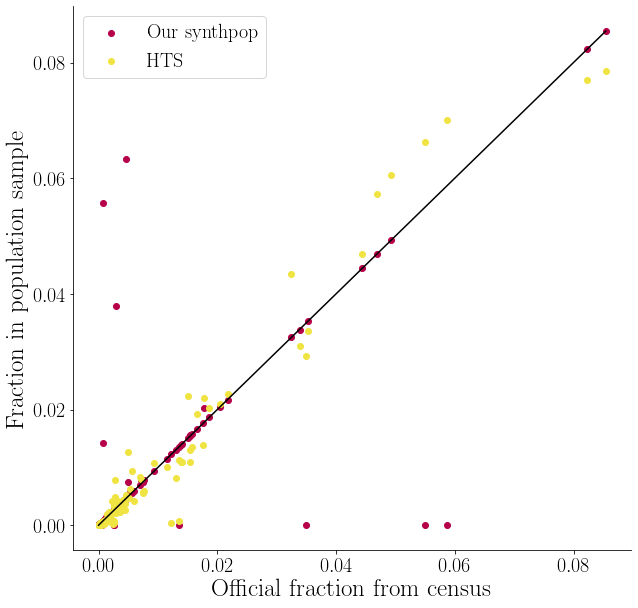

In [32]:
fig, ax = plt.subplots(figsize=(10,10))

minval = 0
maxval = max(compdf['vol_census'].max(),compdf['vol_synthpop'].max(),compdf['vol_egt'].max())
ax.plot([0, maxval], [0, maxval], color='k')

ax.scatter(compdf['vol_census'], compdf['vol_synthpop'], color=color_dict['synthpop'], label='Our synthpop')
ax.scatter(compdf['vol_census'], compdf['vol_egt'], color=color_dict['HTS'], label='HTS')

#ax.set_xscale('log')
#ax.set_yscale('log')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xlabel('Official fraction from census')
ax.set_ylabel('Fraction in population sample')
plt.legend()


outpath = os.path.join(config['outfig_dir'], 'socioecofit.pdf')
plt.savefig(outpath, bbox_inches='tight')
plt.show()

<a id='zonepop'></a>
***
# Comparing population of each zone, our synthpop vs eqasim
* [Back to summary](#summary)

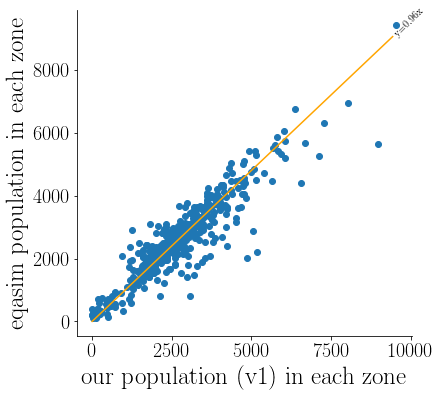

In [33]:
k=list(synthpops.keys())[0]
synthpop = synthpops[k]

synthpop['iris_or_commune'] = synthpop['iris_or_commune'].astype(float)

gis_pop = (perxhome
           .groupby('iris_or_commune').size().rename('pop_eqasim').reset_index()
          .merge(synthpop.groupby('iris_or_commune').size().rename('pop_bm').reset_index(),
                 on='iris_or_commune',
                 how='outer'
                )
          )

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(gis_pop['pop_eqasim'], gis_pop['pop_bm'])
minval = min(gis_pop['pop_eqasim'].min(), gis_pop['pop_bm'].min())
maxval = min(gis_pop['pop_eqasim'].max(), gis_pop['pop_bm'].max())

recaling_coef = gis_pop['pop_bm'].sum()/gis_pop['pop_eqasim'].sum()
#ax.plot([minval,maxval], [minval,maxval], c='gray')
#ax.text(maxval, maxval, 'y=x', rotation=45)

ax.plot([minval,maxval], [minval*recaling_coef, maxval*recaling_coef], c='orange')
ax.text(maxval, maxval*recaling_coef, 'y={:.2f}x'.format(recaling_coef), rotation=45)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('our population ({}) in each zone'.format(k))
ax.set_ylabel('eqasim population in each zone')

plt.show()

<a id='homestart'></a>
***
# Agendas that don't start at `home`
* [Back to summary](#summary)

In [34]:
k=list(synthpops.keys())[0]
synthpops[k]

,iris_or_commune,gender,has_car,occupation,age,home_status,main_transport_work,id_agenda,dep_0_motif,dep_0_zone,...,dep_7_distbin,dep_8_distbin,dep_9_distbin,dep_10_distbin,autonomy,work_tm_in_agenda,work_in_agenda,study_in_agenda,need_commute,agent_id
0,69288.0,0,1,6,1,0,2,1320021221,0.0,69288.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,0
1,692770103.0,1,1,4,2,2,2,1320021221,0.0,692770103.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,1
2,690890201.0,0,1,7,0,0,-1,1320021221,0.0,690890201.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,2
3,692730103.0,0,1,7,0,0,-1,1320021221,0.0,692730103.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,3
4,691490301.0,0,1,7,0,0,-1,1320021221,0.0,691490301.0,...,NaN,NaN,NaN,NaN,2.0,2.0,True,False,True,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1325934,693860403.0,1,1,7,1,0,2,237001222,0.0,693860403.0,...,NaN,NaN,NaN,NaN,0.0,NaN,False,False,False,1325934
1325935,693850603.0,1,1,4,1,0,2,237001222,0.0,693850603.0,...,NaN,NaN,NaN,NaN,0.0,NaN,False,False,False,1325935
1325936,693880701.0,0,1,0,3,0,-1,237001222,0.0,693880701.0,...,NaN,NaN,NaN,NaN,0.0,NaN,False,False,False,1325936
1325937,693850203.0,1,1,4,2,2,-1,237001222,0.0,693850203.0,...,NaN,NaN,NaN,NaN,0.0,NaN,False,False,False,1325937


In [35]:
nb_start_not_home = (synthpops[k]['dep_0_motif']!=0).sum()
nb_tot = len(synthpops[k])

print('{} agents out of {} ({:.2%}) do not start at home'.format(nb_start_not_home, nb_tot,
                                                                 nb_start_not_home/nb_tot))

26026 agents out of 1325939 (1.96%) do not start at home


<a id='static'></a>
***
# Counting static agendas
* [Back to summary](#summary)

<a id='staticeqasim'></a>
## Static agendas in eqasim
* [Back to summary](#summary)

In [36]:
nb_diff_zones = (resident_activities_df
                 .groupby(['person_id', 'iris_or_commune'], dropna=False).size()
                 .groupby('person_id').size())
nb_static=(nb_diff_zones==1).sum()

nb_empty = (resident_activities_df['start_time'].isna() & resident_activities_df['end_time'].isna()).sum()
print('{} agendas out of {} are empty ({:.2f}%)'.format(nb_empty, 
                                                          len(nb_diff_zones),
                                                          100*nb_empty/len(nb_diff_zones)))


print('{} agendas out of {} are non-empty but still static ({:.2f}%)'.format(nb_static-nb_empty, 
                                                          len(nb_diff_zones),
                                                          100*(nb_static-nb_empty)/len(nb_diff_zones)))


169445 agendas out of 1380349 are empty (12.28%)
67996 agendas out of 1380349 are non-empty but still static (4.93%)


<a id='staticsynthpop'></a>
## Static agendas in our synthpop
* [Back to summary](#summary)

In [37]:
def get_static_col(synthpop):
    max_chain_len = int(synthpop['chain_len'].max())
    zone_cols = ['dep_{}_zone'.format(i) for i in range(max_chain_len+1)]
    synthpop[zone_cols] = synthpop[zone_cols].fillna(0)
    locations_sampled = synthpop[zone_cols].values
    moved = (locations_sampled[:,1:] != locations_sampled[:,:-1])
    padding = locations_sampled[:,1:]==0
    static_col = (~(moved & ~padding)).all(axis=1)
    return static_col

print('    {:>10}\t{:>10}'.format('frac of empty agendas', 'frac of non-empty static agendas'))
for k, synthpop in synthpops.items():
    synthpop['is_static'] = get_static_col(synthpop)
    synthpop['is_empty'] = synthpop['chain_len']==0
    non_empty_static_frac = (synthpop['is_static'] & ~synthpop['is_empty']).mean()
    empty_frac = synthpop['is_empty'].mean()
    print('{}\t{:>10.2f}%\t{:>10.2f}%'.format(k, 100*empty_frac, 100*non_empty_static_frac))
    

    frac of empty agendas	frac of non-empty static agendas
v1	     21.19%	      1.30%
v3	     17.72%	      7.98%
v8	     17.72%	     42.46%
v8h2	     21.19%	      9.90%
v9h6	     21.19%	      7.39%


<a id='od'></a>
# Comparing OD matrices
* [Back to summary](#summary)

In [38]:
from scipy.stats import gaussian_kde
from utils.scatter_with_hist import scatter_with_hist

min_vol_r2log = 5
min_vol_cross_entropy = 0
min_vol_viz = 4

<a id='odeqasim'></a>
## Computing matrix of eqasim
* [Back to summary](#summary)

In [39]:

# fitting hour to timesteps
timesteps = np.array(config['timesteps'])
resident_trips_df['tagg'] = timesteps[np.searchsorted(timesteps, resident_trips_df['t'], side='right')-1]

# grouping
odm_eqasim = (resident_trips_df
              .groupby(['o', 'd', 'tagg'])
              .size().reset_index()
              .rename(columns={0:'vol', 'tagg':'t'}))
odm_eqasim.head()

,o,d,t,vol
0,1043.0,1043.0,0,20
1,1043.0,1043.0,2,15
2,1043.0,1043.0,5,136
3,1043.0,1043.0,7,592
4,1043.0,1043.0,8,1076


<a id='odsynthpop'></a>
## Computing matrix of our synthpop
* [Back to summary](#summary)

In [40]:
c = Chrono('Computing OD matrix of synthpops...')
synthpop_od_dict  = {}
for k, synthpop_trips in synthpop_trips_dict.items():
    c.write(k)
    synthpop_od = synthpop_trips.groupby(['o', 'd', 't']).size().rename('vol').reset_index()
    synthpop_od['o'] = synthpop_od['o'].astype(int)
    synthpop_od['d'] = synthpop_od['d'].astype(int)
    synthpop_od['t'] = synthpop_od['t'].astype(int)
    synthpop_od_dict[k] = synthpop_od
c.done()

11:48:04	Computing OD matrix of synthpops...
00:00:00	v1
00:00:00	v3
00:00:02	v8
00:00:02	v8h2
00:00:03	v9h6
00:00:04	Work complete !


<a id='odcomppd'></a>
## Comparing P(D | O, T) in OD matrices
* [Back to summary](#summary)

In [41]:

def get_comp_proba_d(odm_x, odm_y, min_vol=0):
    compdf = odm_x.merge(odm_y, on = ('o', 'd', 't'), how='outer', suffixes=('_x','_y'))
    compdf['vol_x'] = compdf['vol_x'].fillna(0)
    compdf['vol_y'] = compdf['vol_y'].fillna(0)
    
    compdf['proba_d_x'] = compdf['vol_x'] / compdf.groupby(['o', 't'])['vol_x'].transform(sum)
    compdf['proba_d_y'] = compdf['vol_y'] / compdf.groupby(['o', 't'])['vol_y'].transform(sum)
    
    compdf_no_zero = compdf.loc[(compdf['vol_x']>=min_vol) & 
                                (compdf['vol_y']>=min_vol)]
    
    # X_no_static = compdf_no_zero[compdf_no_zero['o']!=compdf_no_zero['d']]['proba_d_mod']
    # Y_no_static = compdf_no_zero[compdf_no_zero['o']!=compdf_no_zero['d']]['proba_d_synthpop']    
    # X_static = compdf_no_zero[compdf_no_zero['o']==compdf_no_zero['d']]['proba_d_mod']
    # Y_static = compdf_no_zero[compdf_no_zero['o']==compdf_no_zero['d']]['proba_d_synthpop']
    # scatter_with_hist(ax, X_no_static, Y_no_static, scale='log',marker_size = 1, alpha=0.5, title=title)
    # ax.scatter(X_static, Y_static, s=1, alpha=0.5)

    return compdf_no_zero

def get_MSE(X,Y):
    return ((X-Y)**2).mean()

def get_R2_log(X,Y):
    Xl = np.log(X)
    Yl = np.log(Y)
    return 1-np.sum((Xl-Yl)**2)/np.sum((Yl-Yl.mean())**2)

#def get_R2(X,Y):
#    return 1-np.sum((X-Y)**2)/np.sum((Y-Y.mean())**2)
def get_R2(X, Y, nb_cells):
    Y_mean = Y.sum()/nb_cells
    return 1-np.sum((X-Y)**2)/np.sum((Y-Y_mean)**2)

def get_cross_entropy_proba_d(compdf, nb_zones, eps=1e-10):
    compdf['proba_d_x'] = compdf['proba_d_x'] + eps
    compdf['proba_d_y'] = compdf['proba_d_y'] + eps
    
    empty_compdf = compdf.groupby(['o', 't'])[['proba_d_x']].agg(['size', 'sum']).reset_index()
    empty_compdf.columns = ["_".join(col_name).rstrip('_') for col_name in empty_compdf.columns.to_flat_index()]
    
    empty_compdf['nb_empty_od'] = nb_zones - empty_compdf['proba_d_x_size']
    empty_compdf['total_potential'] = empty_compdf['proba_d_x_sum'] + empty_compdf['nb_empty_od']*eps
    empty_compdf['eps_norm'] = eps/empty_compdf['total_potential']
    empty_compdf['cross_entropy_empty'] = -empty_compdf['nb_empty_od']*empty_compdf['eps_norm']*np.log(empty_compdf['eps_norm'])
    empty_compdf['kldiv_empty'] = 0 # log(1)

    compdf = compdf.merge(empty_compdf[['o','t','total_potential']], on=['o', 't'])

    compdf['proba_d_x'] = compdf['proba_d_x']/compdf['total_potential']
    compdf['proba_d_y'] = compdf['proba_d_y']/compdf['total_potential']
    compdf['cross_entropy'] = -compdf['proba_d_x']*np.log(compdf['proba_d_y'])
    compdf['kldiv'] = compdf['proba_d_x']*np.log(compdf['proba_d_x']/compdf['proba_d_y'])
    
    compdf_report = compdf.groupby(['o', 't'])[['cross_entropy', 'kldiv']].sum().reset_index()
    compdf_report = compdf_report.merge(empty_compdf, on=['o', 't'])
    compdf_report['cross_entropy_total'] = compdf_report['cross_entropy'] + compdf_report['cross_entropy_empty']
    compdf_report['kldiv_total'] = compdf_report['kldiv'] + compdf_report['kldiv_empty']

    return compdf_report['cross_entropy_total'].mean(), compdf_report['kldiv_total'].mean()

def get_support_iou_proba_d(compdf):
    """
    intersection over union of the supports of the distributions P(D|O,T)
    described in pd.DataFrame compdf
    /!\ make sure compdf has been asked with min_vol=0
    """
    def iou_agg(rows):
        return ((rows['proba_d_x']>0) & (rows['proba_d_y']>0)).sum()/len(rows)
    
    return compdf.groupby(['o', 't']).apply(iou_agg).mean()


In [150]:
def get_perf_report_proba_d(odm, eps=1e-30):
    compdf = get_comp_proba_d(transition_matrix, odm, min_vol=min_vol_r2log)
    r2_log = get_R2_log(compdf['proba_d_x'], compdf['proba_d_y'])
    
    compdf = get_comp_proba_d(transition_matrix, odm, min_vol=min_vol_cross_entropy)
    cross_entropy, kldiv = get_cross_entropy_proba_d(compdf, nb_zones=len(iris_commune), eps=eps)
    
    compdf = get_comp_proba_d(transition_matrix, odm, min_vol=0)
    support_iou = get_support_iou_proba_d(compdf)
        
    report_row = {'R2_log'        : '{:.2g}'.format(r2_log),
                  'Cross_entropy' : '{:.3g}'.format(cross_entropy),
                  'KL divergence' : '{:.3g}'.format(kldiv),
                  'support iou'   : '{:.3g}'.format(support_iou),
                 }
    return report_row
    
    
report_df = pd.DataFrame()

c = Chrono('Computing perf_report for p(d|o,t)...')
for k, synthpop_od in synthpop_od_dict.items():
    c.write(k)
    report_row = get_perf_report_proba_d(synthpop_od)
    report_df = pd.concat([report_df, pd.DataFrame(report_row, index=[k])])
c.done()
report_row = get_perf_report_proba_d(odm_eqasim)
report_df = pd.concat([report_df, pd.DataFrame(report_row, index=['eqasim'])])
print('p(d|o,t)')
report_df

15:28:59	Computing perf_report for p(d|o,t)...
00:00:00	v1
00:00:15	v3
00:00:27	v8
00:00:38	v8h2
00:00:48	v9h6
00:00:59	Work complete !
p(d|o,t)


,R2_log,Cross_entropy,KL divergence,support iou,MSSIM
v1,0.94,16.8,12.6,0.368,0.0232
v3,0.84,18.1,13.9,0.392,0.0211
v8,0.77,31,26.8,0.159,0.0112
v8h2,0.87,21.5,17.3,0.33,0.0206
v9h6,0.65,21.2,17,0.375,0.0197
eqasim,0.56,29.8,25.6,0.28,0.0163


<a id='odcomppdviz'></a>
## Comparison viz of P(D | O, T) in OD matrices
* [Back to summary](#summary)

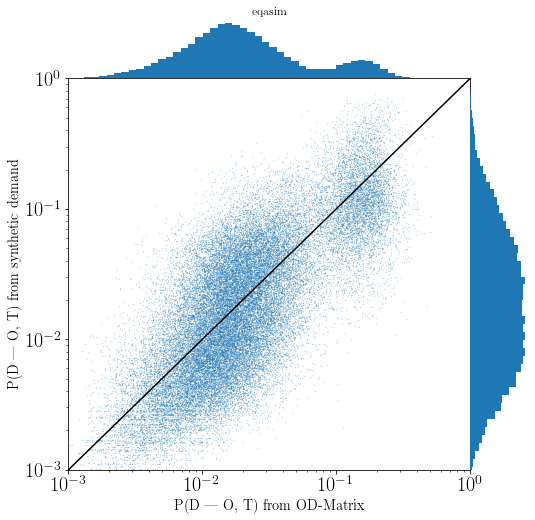

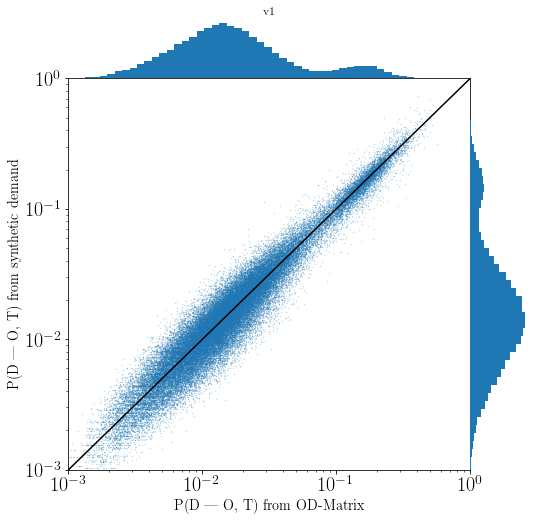

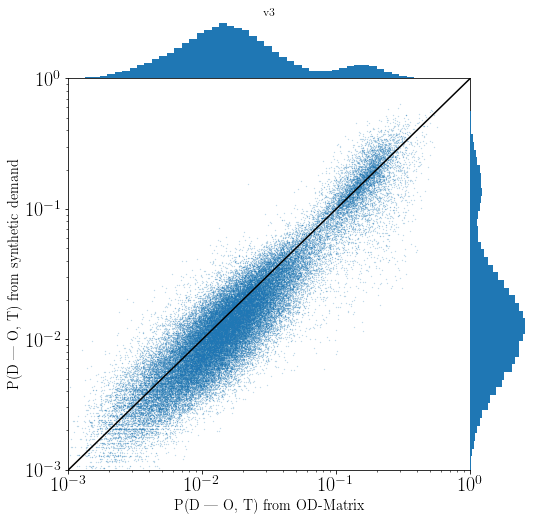

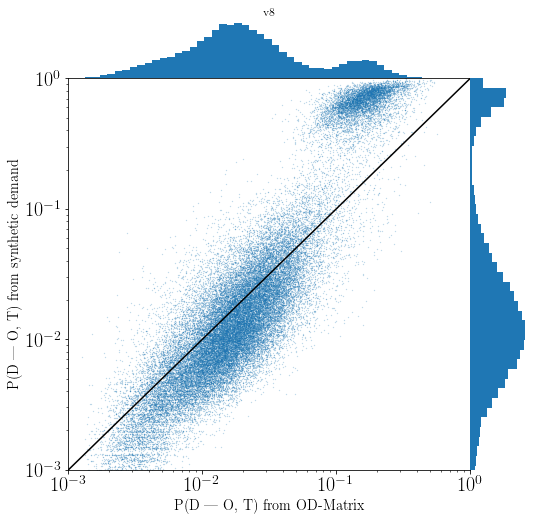

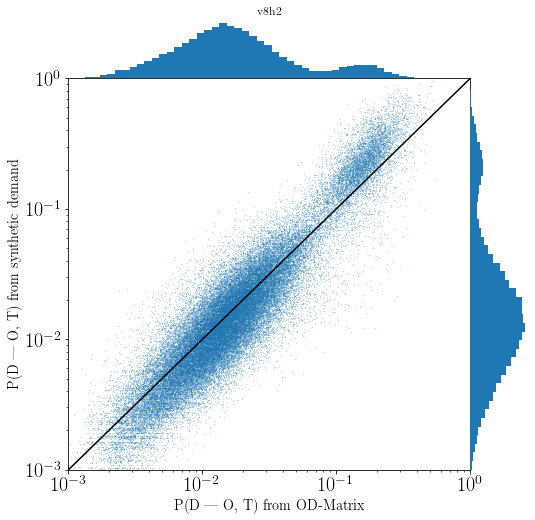

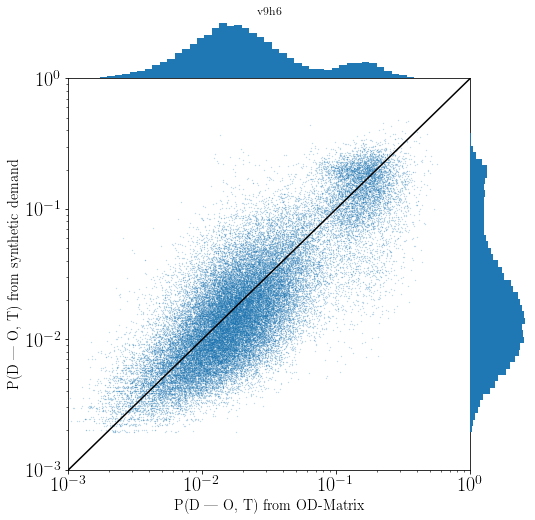

In [43]:
def plot_odm_comparison(odm, title=None):
    
    compdf = get_comp_proba_d(transition_matrix, odm, min_vol=min_vol_viz)
    X, Y = compdf['proba_d_x'], compdf['proba_d_y']
    
    fig, ax= plt.subplots(figsize=(8,8))
    
    ax.set_xlabel('P(D | O, T) from OD-Matrix', fontsize='x-large')
    ax.set_ylabel('P(D | O, T) from synthetic demand', fontsize='x-large')
    
    scatter_with_hist(ax, X, Y, scale='log', marker_size = 0.05, alpha=0.5, title=title)
    
    
    
    ## density plot
    #nbins=50
    #ker = gaussian_kde([X,Y])
    ## xi, yi = np.mgrid[min_val:max_val:nbins*1j, min_val:max_val:nbins*1j]
    #xi, yi = np.meshgrid(np.logspace(-4.0,0.0, num=nbins), np.logspace(-4.0,0.0, num=nbins))
    #zi = ker(np.vstack([xi.flatten(), yi.flatten()]))
    #ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.OrRd)
    
    
    min_val = 1e-3#min(X.min(), Y.min())
    max_val = 1#min(X.max(), Y.max())
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.plot([min_val,max_val], [min_val,max_val], color='k')
    
    plt.show()
    

plot_odm_comparison(odm_eqasim, title='eqasim')
#k = 'v1'
#synthpop_od = synthpop_od_dict[k]
#plot_odm_comparison(synthpop_od, title=k)
#
#k = 'v9h'
#synthpop_od = synthpop_od_dict[k]
#plot_odm_comparison(synthpop_od, title=k)
    
for k, synthpop_od in synthpop_od_dict.items():
    plot_odm_comparison(synthpop_od, title=k)


<a id='odcomppod'></a>
## Comparing P(O, D | T) in OD matrices
* [Back to summary](#summary)

In [222]:
def get_comp_proba_od(odm_x, odm_y, min_vol=0):
    compdf = odm_x.merge(odm_y, on = ('o', 'd', 't'), how='outer', suffixes=('_x','_y'))
    compdf['vol_x'] = compdf['vol_x'].fillna(0)
    compdf['vol_y'] = compdf['vol_y'].fillna(0)
    
    compdf['proba_od_x'] = compdf['vol_x'] / compdf.groupby(['t'])['vol_x'].transform(sum)
    compdf['proba_od_y'] = compdf['vol_y'] / compdf.groupby(['t'])['vol_y'].transform(sum)
    
    compdf_no_zero = compdf.loc[(compdf['vol_x']>=min_vol) & 
                                (compdf['vol_y']>=min_vol)]
    
    X = compdf_no_zero['proba_od_x']
    Y = compdf_no_zero['proba_od_y']
    return compdf_no_zero


def get_cross_entropy_proba_od(compdf, nb_zones, eps=1e-9):
    compdf['proba_od_x'] = compdf['proba_od_x'] + eps
    compdf['proba_od_y'] = compdf['proba_od_y'] + eps
    
    empty_compdf = compdf.groupby(['t'])[['proba_od_x']].agg(['size', 'sum']).reset_index()
    empty_compdf.columns = ["_".join(col_name).rstrip('_') for col_name in empty_compdf.columns.to_flat_index()]
    
    empty_compdf['nb_empty_od'] = nb_zones**2 - empty_compdf['proba_od_x_size']
    empty_compdf['total_potential'] = empty_compdf['proba_od_x_sum'] + empty_compdf['nb_empty_od']*eps
    empty_compdf['eps_norm'] = eps/empty_compdf['total_potential']
    empty_compdf['cross_entropy_empty'] = -empty_compdf['nb_empty_od']*empty_compdf['eps_norm']*np.log(empty_compdf['eps_norm'])

    compdf = compdf.merge(empty_compdf[['t','total_potential']], on=['t'])

    compdf['proba_od_x'] = compdf['proba_od_x']/compdf['total_potential']
    compdf['proba_od_y'] = compdf['proba_od_y']/compdf['total_potential']
    compdf['cross_entropy'] = -compdf['proba_od_x']*np.log(compdf['proba_od_y'])
    compdf['kldiv'] = compdf['proba_od_x']*np.log(compdf['proba_od_x']/compdf['proba_od_y'])

    compdf_report = compdf.groupby(['t'])[['cross_entropy', 'kldiv']].sum().reset_index()
    compdf_report = compdf_report.merge(empty_compdf, on=['t'])
    compdf_report['cross_entropy_total'] = compdf_report['cross_entropy'] + compdf_report['cross_entropy_empty']
    compdf_report['kldiv_total'] = compdf_report['kldiv'] # + 0 for empty

    return compdf_report['cross_entropy_total'].mean(), compdf_report['kldiv_total'].mean()


def get_support_iou_proba_od(compdf):
    """
    intersection over union of the supports of the distributions P(O,D|T)
    described in pd.DataFrame compdf
    /!\ make sure compdf has been asked with min_vol=0
    """
    def iou_agg(rows):
        return ((rows['proba_od_x']>0) & (rows['proba_od_y']>0)).sum()/len(rows)
    
    return compdf.groupby(['t']).apply(iou_agg).mean()

def get_mssim(compdf, nb_zones):
    L = 100
    c1 = (0.01*L)**2
    c2 = (0.03*L)**2
    
    compdf['vol2_x'] = compdf['vol_x']**2
    compdf['vol2_y'] = compdf['vol_y']**2
    compdf['vol_xy'] = compdf['vol_x']*compdf['vol_y']
    
    ssimo = compdf.groupby(['o','t'])[['vol_x', 'vol2_x', 'vol_y', 'vol2_y', 'vol_xy']].sum().reset_index()
    ssimo['mu_x'] = ssimo['vol_x']/nb_zones
    ssimo['s2_x'] = ssimo['vol2_x']/nb_zones - ssimo['mu_x']**2
    ssimo['mu_y'] = ssimo['vol_y']/nb_zones
    ssimo['s2_y'] = ssimo['vol2_y']/nb_zones - ssimo['mu_y']**2
    ssimo['s_xy'] = ssimo['vol_xy']/nb_zones - ssimo['mu_x']*ssimo['mu_y']


    ssimo['ssim'] = (2*ssimo['mu_x']*ssimo['mu_y'] + c1) * (2*ssimo['s_xy'] + c2) / ((ssimo['mu_x']**2 + ssimo['mu_y']**2 + c1) * (ssimo['s2_x'] + ssimo['s2_y'] + c2))
    mssimo = ssimo['ssim'].sum()/nb_zones**2
    
    ssimd = compdf.groupby(['d'])[['vol_x', 'vol2_x', 'vol_y', 'vol2_y', 'vol_xy']].sum().reset_index()
    ssimd['mu_x'] = ssimd['vol_x']/nb_zones
    ssimd['s2_x'] = ssimd['vol2_x']/nb_zones - ssimd['mu_x']**2
    ssimd['mu_y'] = ssimd['vol_y']/nb_zones
    ssimd['s2_y'] = ssimd['vol2_y']/nb_zones - ssimd['mu_y']**2
    ssimd['s_xy'] = ssimd['vol_xy']/nb_zones - ssimd['mu_x']*ssimd['mu_y']

    ssimd['ssim'] = (2*ssimd['mu_x']*ssimd['mu_y'] + c1) * (2*ssimd['s_xy'] + c2) / ((ssimd['mu_x']**2 + ssimd['mu_y']**2 + c1) * (ssimd['s2_x'] + ssimd['s2_y'] + c2))
    mssimd = ssimd['ssim'].sum()/nb_zones**2
    
    return mssimo, mssimd

def get_perf_report_proba_od(odm, eps=1e-30):
    compdf = get_comp_proba_od(transition_matrix, odm, min_vol=min_vol_r2log)
    r2_log = get_R2_log(compdf['proba_od_x'], compdf['proba_od_y'])
    
    compdf = get_comp_proba_od(transition_matrix, odm, min_vol=min_vol_cross_entropy)
    cross_entropy, kldiv = get_cross_entropy_proba_od(compdf, nb_zones=len(iris_commune), eps=eps)
    
    compdf = get_comp_proba_od(transition_matrix, odm, min_vol=0)
    r2 = get_R2(compdf['proba_od_x'], compdf['proba_od_y'], 515**2)
    
    
    # counting the fraction of the sse that is explained by the 1% most contributing flows
    sse = (compdf['proba_od_x'] - compdf['proba_od_y'])**2
    thres = np.quantile(sse, 0.95)
    big_errors = sse[sse>=thres]
    sse_frac_1pct = big_errors.sum()/sse.sum()
    
    mssimo, mssimd = get_mssim(compdf, nb_zones=len(iris_commune))

    support_iou = get_support_iou_proba_od(compdf)
            
    report_row = {'R2_log'        : '{:.2f}'.format(r2_log),
                  'R2'            : '{:.2f}'.format(r2),
                  'Cross_entropy' : '{:.2f}'.format(cross_entropy),
                  'KL divergence' : '{:.2f}'.format(kldiv),
                  'mssimo' : '{:.4f}'.format(mssimo),
                  'mssimd' : '{:.4f}'.format(mssimd),
                  'support iou'   : '{:.2f}'.format(support_iou),
                  'frac of sse explained by the top 5%' : '{:.2%}'.format(sse_frac_1pct),
                 }
    return report_row
    
    
report_df = pd.DataFrame()

for k, synthpop_od in synthpop_od_dict.items():
    report_row = get_perf_report_proba_od(synthpop_od)
    report_df = pd.concat([report_df, pd.DataFrame(report_row, index=[k])])

report_row = get_perf_report_proba_od(odm_eqasim)
report_df = pd.concat([report_df, pd.DataFrame(report_row, index=['eqasim'])])

print('p(o,d|t)')
report_df

p(o,d|t)


,R2_log,R2,Cross_entropy,KL divergence,mssimo,mssimd,support iou,frac of sse explained by the top 5%
v1,0.75,0.94,20.42,9.96,0.0232,0.0009,0.38,91.78%
v3,0.47,0.87,21.88,11.42,0.0211,0.0008,0.40,94.01%
v8,0.56,0.54,32.44,21.98,0.0112,0.0003,0.16,99.56%
v8h2,0.63,0.87,23.47,13.02,0.0206,0.0014,0.35,95.60%
v9h6,0.28,0.79,25.40,14.94,0.0197,0.0004,0.38,94.82%
eqasim,0.25,0.77,31.95,21.49,0.0163,0.0001,0.30,94.93%


<a id='odcomppodviz'></a>
## Comparison viz of P(O, D | T) in OD matrices
* [Back to summary](#summary)

In [45]:
def pretty_scatter_with_hist(ax, X, Y, title=None, plot_density=True, marker_size=0.02, alpha=0.5):
    min_val = max(X.min(), Y.min())
    max_val = min(X.max(), Y.max())
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)

    if plot_density:
        nbins=100
        ker = gaussian_kde([X,Y])
        # xi, yi = np.mgrid[min_val:max_val:nbins*1j, min_val:max_val:nbins*1j]
        xi, yi = np.meshgrid(np.logspace(np.log10(min_val), np.log10(max_val), num=nbins),
                             np.logspace(np.log10(min_val), np.log10(max_val), num=nbins))
        zi = ker(np.vstack([xi.flatten(), yi.flatten()]))
        ax.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap=plt.cm.OrRd)
    
    
    scatter_with_hist(ax, X, Y, scale='log', marker_size=marker_size, alpha=alpha, title=title,
                      color='k', hist_color=(0.5,0,0))
    
    ax.plot([min_val,max_val], [min_val,max_val], color='k')
    
min_vol_viz=5
def plot_odm_comparison(odm, title=None):
    
    compdf = get_comp_proba_od(transition_matrix, odm, min_vol=min_vol_viz)
    X, Y = compdf['proba_od_x'], compdf['proba_od_y']
    
    #X_static = compdf[compdf['o']==compdf['d']]['proba_od_x']
    #Y_static = compdf[compdf['o']==compdf['d']]['proba_od_y']
    
    fig, ax= plt.subplots(figsize=(8,8))
    pretty_scatter_with_hist(ax, X, Y)
    #ax.scatter(X_static, Y_static, s = 0.02, color='r')

    ax.set_xlabel('$y^*_{{o,d,t}}$ from OD Matrices')
    ax.set_ylabel('$\hat{{y}}_{{o,d,t}}$ from {}'.format(title))

    
    #outpath = os.path.join(config['outfig_dir'], 'scat_{}.png'.format(title))
    outpath = os.path.join(config['outfig_dir'], 'scat_{}.pdf'.format(title))
    plt.savefig(outpath, bbox_inches='tight')
    plt.show()


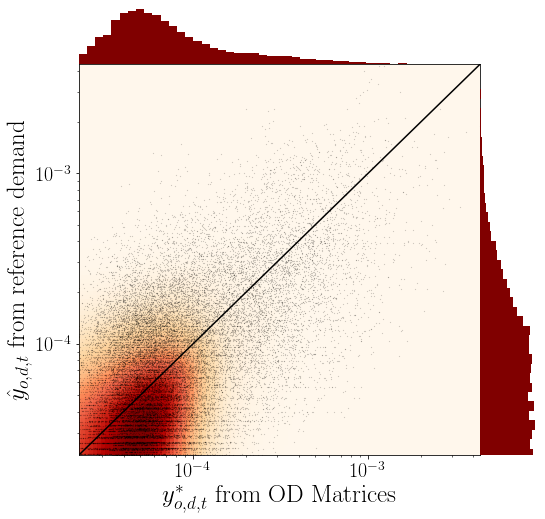

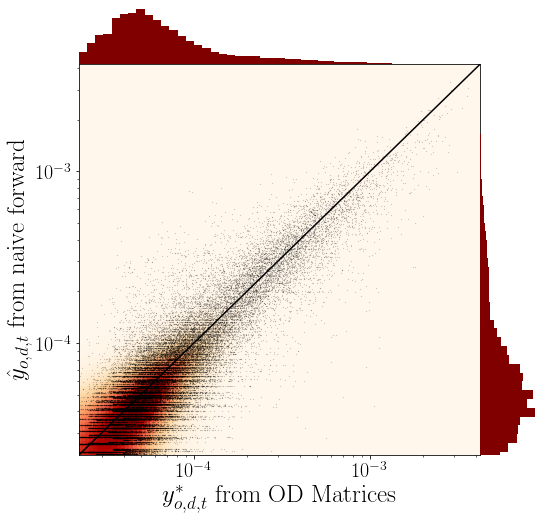

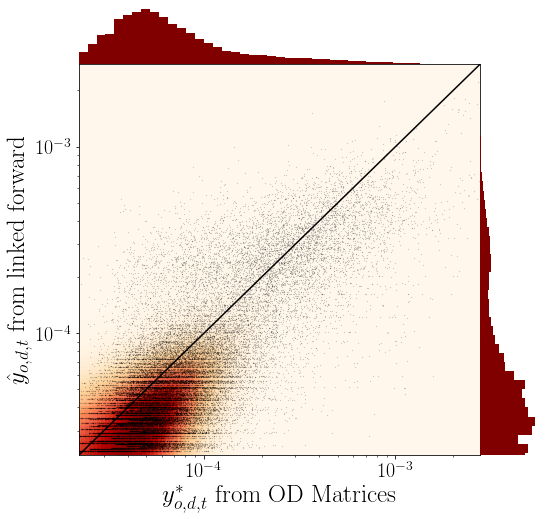

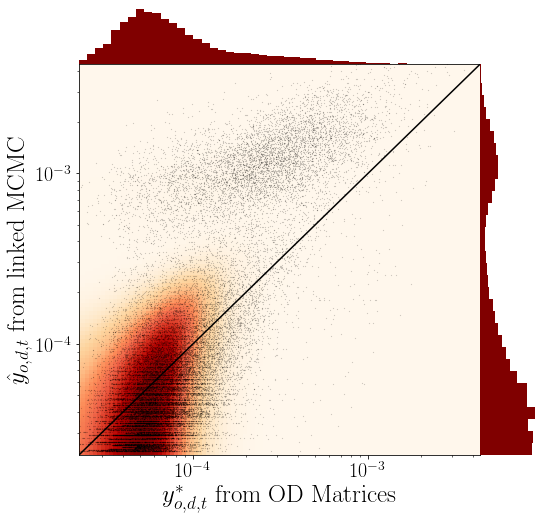

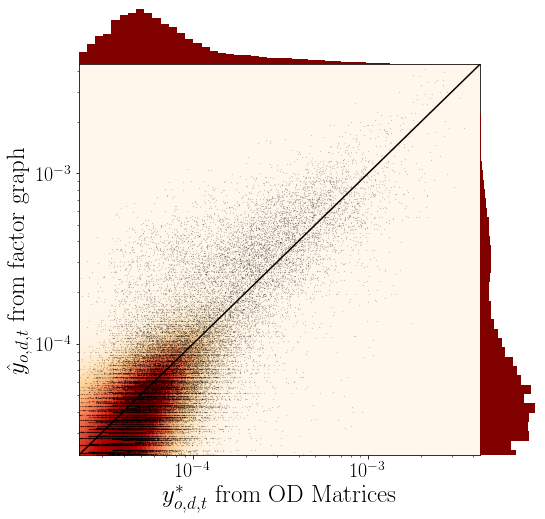

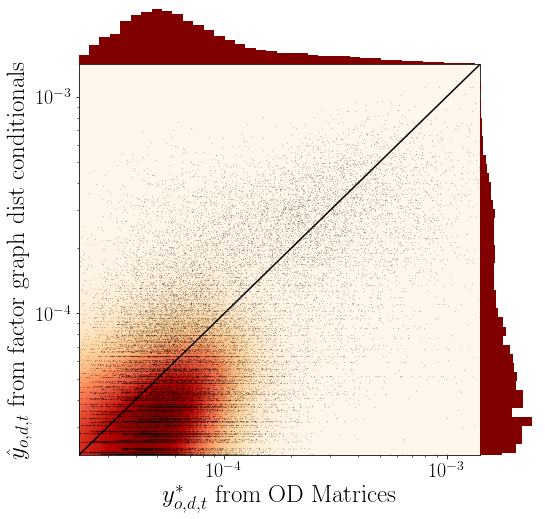

In [46]:
labels_dicts = { 
                'v1':'naive forward',
                'v3':'linked forward',
                'v8':'linked MCMC',
                'v8h2':'factor graph',
                'v9h6':'factor graph dist conditionals',
                'eqasim':'reference demand'
               }



plot_odm_comparison(odm_eqasim, title='reference demand')
# k=list(synthpops.keys())[-1]
# synthpop_od = synthpop_od_dict[k]
# plot_odm_comparison(synthpop_od, title=k)

for k, synthpop_od in synthpop_od_dict.items():
    plot_odm_comparison(synthpop_od, title=labels_dicts[k])


<a id='odcomppo'></a>
## Comparing P(O | D, T) in OD matrices
* [Back to summary](#summary)

In [47]:

def get_comp_proba_o(odm_x, odm_y, min_vol=0):
    compdf = odm_x.merge(odm_y, on = ('o', 'd', 't'), how='outer', suffixes=('_x','_y'))
    compdf['vol_x'] = compdf['vol_x'].fillna(0)
    compdf['vol_y'] = compdf['vol_y'].fillna(0)
    
    compdf['proba_o_x'] = compdf['vol_x'] / compdf.groupby(['d', 't'])['vol_x'].transform(sum)
    compdf['proba_o_y'] = compdf['vol_y'] / compdf.groupby(['d', 't'])['vol_y'].transform(sum)
    
    compdf_no_zero = compdf.loc[(compdf['vol_x']>=min_vol) & 
                                (compdf['vol_y']>=min_vol)]
    
    return compdf_no_zero


def get_cross_entropy_proba_o(compdf, nb_zones, eps=1e-10):
    compdf['proba_o_x'] = compdf['proba_o_x'] + eps
    compdf['proba_o_y'] = compdf['proba_o_y'] + eps
    
    empty_compdf = compdf.groupby(['d', 't'])[['proba_o_x']].agg(['size', 'sum']).reset_index()
    empty_compdf.columns = ["_".join(col_name).rstrip('_') for col_name in empty_compdf.columns.to_flat_index()]
    
    empty_compdf['nb_empty_od'] = nb_zones - empty_compdf['proba_o_x_size']
    empty_compdf['total_potential'] = empty_compdf['proba_o_x_sum'] + empty_compdf['nb_empty_od']*eps
    empty_compdf['eps_norm'] = eps/empty_compdf['total_potential']
    empty_compdf['cross_entropy_empty'] = -empty_compdf['nb_empty_od']*empty_compdf['eps_norm']*np.log(empty_compdf['eps_norm'])
    empty_compdf['kldiv_empty'] = 0 # log(1)

    compdf = compdf.merge(empty_compdf[['d','t','total_potential']], on=['d', 't'])

    compdf['proba_o_x'] = compdf['proba_o_x']/compdf['total_potential']
    compdf['proba_o_y'] = compdf['proba_o_y']/compdf['total_potential']
    compdf['cross_entropy'] = -compdf['proba_o_x']*np.log(compdf['proba_o_y'])
    compdf['kldiv'] = compdf['proba_o_x']*np.log(compdf['proba_o_x']/compdf['proba_o_y'])
    
    compdf_report = compdf.groupby(['d', 't'])[['cross_entropy', 'kldiv']].sum().reset_index()
    compdf_report = compdf_report.merge(empty_compdf, on=['d', 't'])
    compdf_report['cross_entropy_total'] = compdf_report['cross_entropy'] + compdf_report['cross_entropy_empty']
    compdf_report['kldiv_total'] = compdf_report['kldiv'] + compdf_report['kldiv_empty']

    return compdf_report['cross_entropy_total'].mean(), compdf_report['kldiv_total'].mean()

def get_support_iou_proba_o(compdf):
    """
    intersection over union of the supports of the distributions P(D|O,T)
    described in pd.DataFrame compdf
    /!\ make sure compdf has been asked with min_vol=0
    """
    def iou_agg(rows):
        return ((rows['proba_o_x']>0) & (rows['proba_o_y']>0)).sum()/len(rows)
    
    return compdf.groupby(['d', 't']).apply(iou_agg).mean()

def get_perf_report_proba_o(odm, eps=1e-30):
    compdf = get_comp_proba_o(transition_matrix, odm, min_vol=min_vol_r2log)
    r2_log = get_R2_log(compdf['proba_o_x'], compdf['proba_o_y'])
    
    compdf = get_comp_proba_o(transition_matrix, odm, min_vol=min_vol_cross_entropy)
    cross_entropy, kldiv = get_cross_entropy_proba_o(compdf, nb_zones=len(iris_commune), eps=eps)
    
    compdf = get_comp_proba_o(transition_matrix, odm, min_vol=0)
    support_iou = get_support_iou_proba_o(compdf)
                
    report_row = {'R2_log'        : '{:.2g}'.format(r2_log),
                  'Cross_entropy' : '{:.3g}'.format(cross_entropy),
                  'KL divergence' : '{:.3g}'.format(kldiv),
                  'support iou'   : '{:.3g}'.format(support_iou),
                 }
    return report_row
    
    
report_df = pd.DataFrame()

for k, synthpop_od in synthpop_od_dict.items():

    report_row = get_perf_report_proba_o(synthpop_od)
    report_df = pd.concat([report_df, pd.DataFrame(report_row, index=[k])])

report_row = get_perf_report_proba_o(odm_eqasim)
report_df = pd.concat([report_df, pd.DataFrame(report_row, index=['eqasim'])])

print('p(o|d,t)')
report_df


p(o|d,t)


,R2_log,Cross_entropy,KL divergence,support iou
v1,0.89,20.3,16.1,0.336
v3,0.82,19.8,15.6,0.372
v8,0.77,30.9,26.7,0.169
v8h2,0.88,21.2,17,0.334
v9h6,0.66,21.4,17.2,0.371
eqasim,0.55,29.6,25.4,0.28


<a id='eps_sensitivity'></a>
# Investigating the impact of additive noise on KL-divergence
* We add an $\epsilon$ to the OD matrices so that KL-divergence is defined
* Here we illustrate that the value chosen for $\epsilon$ does not impact the conclusions
* [Back to summary](#summary)

In [48]:
synthpop_kl_dict = {}
epsilons = np.logspace(-30,0,10)

for k, synthpop_od in tqdm(synthpop_od_dict.items()):

    compdf = get_comp_proba_od(transition_matrix, synthpop_od, min_vol=min_vol_cross_entropy)
    kldivs = []
    for eps in epsilons:
        cross_entropy, kldiv = get_cross_entropy_proba_od(compdf, nb_zones=len(iris_commune), eps=eps)
        kldivs += [kldiv]
    synthpop_kl_dict[k]=kldivs

    compdf = get_comp_proba_od(transition_matrix, odm_eqasim, min_vol=min_vol_cross_entropy)
kldivs = []
for eps in epsilons:
    cross_entropy, kldiv = get_cross_entropy_proba_od(compdf, nb_zones=len(iris_commune), eps=eps)
    kldivs += [kldiv]
synthpop_kl_dict['eqasim']=kldivs

100%|█████████████████████████████████████████████| 5/5 [00:50<00:00, 10.15s/it]


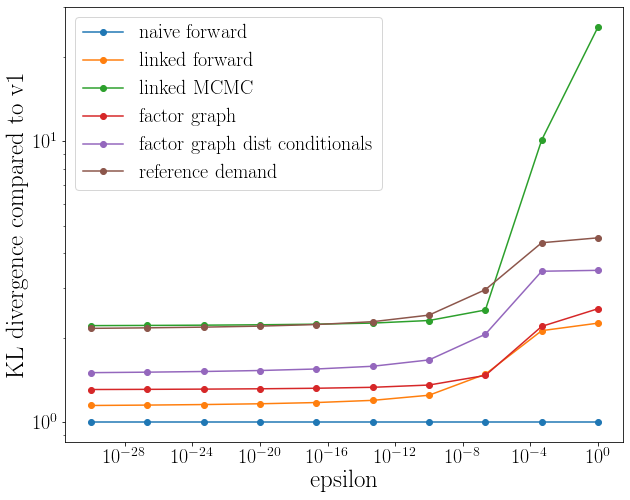

In [49]:

        
color_dict['v3'] = (147/255, 53/255, 177/255)
color_dict['v8'] = (182/255, 0/255, 74/255)
color_dict['v8h2'] = (182/255, 0/255, 74/255)
color_dict['v9h6'] = (182/255, 0/255, 74/255)
color_dict['eqasim'] = (48/255, 190/255, 242/255)

fig, ax = plt.subplots(figsize=(10,8))

for k, synthpop_od in synthpop_kl_dict.items():
    if k in labels_dicts.keys():
        ax.plot(epsilons, np.array(synthpop_kl_dict[k])/np.array(synthpop_kl_dict['v1']), 
                marker='o', label=labels_dicts[k]#, color=color_dict[k]
               )
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('epsilon')
ax.set_ylabel('KL divergence compared to v1')

outpath = os.path.join(config['outfig_dir'], 'eps_sensitivity.pdf')
plt.savefig(outpath, bbox_inches='tight')

plt.show()

In [50]:
np.array(synthpop_kl_dict[k])/np.array(synthpop_kl_dict['v1'])

array([2.15818493, 2.16735266, 2.17989747, 2.19810801, 2.22694215,
       2.27952449, 2.40566603, 2.96385323, 4.35512457, 4.53437275])

<a id='Paper_table'></a>
## Paper table
* [Back to summary](#summary)

In [51]:
report_df = pd.DataFrame()

for k, synthpop_od in synthpop_od_dict.items():
    compdf = get_comp_proba_o(transition_matrix, synthpop_od, min_vol=min_vol_cross_entropy)
    _, kldivo = get_cross_entropy_proba_o(compdf, nb_zones=len(iris_commune), eps=1e-30)

    compdf = get_comp_proba_od(transition_matrix, synthpop_od, min_vol=min_vol_cross_entropy)
    _, kldivod = get_cross_entropy_proba_od(compdf, nb_zones=len(iris_commune), eps=1e-30)

    compdf = get_comp_proba_d(transition_matrix, synthpop_od, min_vol=min_vol_cross_entropy)
    _, kldivd = get_cross_entropy_proba_d(compdf, nb_zones=len(iris_commune), eps=1e-30)

    report_row = {'P(d | o, t)':kldivd,
                 'P(o | d, t)':kldivo,
                  'P(o, d | t)':kldivod
                 }
    report_df = pd.concat([report_df, pd.DataFrame(report_row, index=[k])])


compdf = get_comp_proba_o(transition_matrix, odm_eqasim, min_vol=min_vol_cross_entropy)
_, kldivo = get_cross_entropy_proba_o(compdf, nb_zones=len(iris_commune), eps=1e-30)

compdf = get_comp_proba_od(transition_matrix, odm_eqasim, min_vol=min_vol_cross_entropy)
_, kldivod = get_cross_entropy_proba_od(compdf, nb_zones=len(iris_commune), eps=1e-30)

compdf = get_comp_proba_d(transition_matrix, odm_eqasim, min_vol=min_vol_cross_entropy)
_, kldivd = get_cross_entropy_proba_d(compdf, nb_zones=len(iris_commune), eps=1e-30)

report_row = {'P(d | o, t)': kldivd,
              'P(o | d, t)': kldivo,
              'P(o, d | t)': kldivod
             }

report_df = pd.concat([report_df, pd.DataFrame(report_row, index=['eqasim'])])

report_df


,"P(d | o, t)","P(o | d, t)","P(o, d | t)"
v1,12.622256,16.051482,9.957594
v3,13.915678,15.552234,11.418409
v8,26.803141,26.709030,21.978749
v8h2,17.313636,16.957446,13.015246
v9h6,16.977930,17.219593,14.944518
eqasim,25.555630,25.435539,21.490329


<a id='recreating_true_commute'></a>
***
# Recreating commute matrix

## Getting official commute matrix
* TODO: cut the communes that are cut in the sutdy zone.
* [Back to summary](#summary)


In [52]:
m_path = os.path.join(config['data_dir']['path'], 
                      config['data_dir']['commute_matrix'])

m = pd.read_csv(m_path, sep=';', dtype={'CODGEO':str})
m = m[m['CODGEO'].isin(iris_commune['commune']) & m['DCLT'].isin(iris_commune['commune'])]
m = m.rename(columns={'CODGEO':'home_commune', 'DCLT':'work_commune', 'NBFLUX_C17_ACTOCC15P':'vol'})
nb_commune = m['home_commune'].unique().shape[0]

m

,home_commune,LIBGEO,work_commune,L_DCLT,vol
1502,01043,Beynost,01043,Beynost,383.195428
1504,01043,Beynost,01049,La Boisse,24.252875
1514,01043,Beynost,01249,Miribel,106.712651
1515,01043,Beynost,01262,Montluel,48.505750
1516,01043,Beynost,01275,Neyron,9.701150
...,...,...,...,...,...
666853,69389,Lyon 9e Arrondissement,69385,Lyon 5e Arrondissement,526.738850
666854,69389,Lyon 9e Arrondissement,69386,Lyon 6e Arrondissement,562.911930
666855,69389,Lyon 9e Arrondissement,69387,Lyon 7e Arrondissement,802.361779
666856,69389,Lyon 9e Arrondissement,69388,Lyon 8e Arrondissement,375.167133


<a id='Synthpop_commute'></a>
## Synthpop commute
* [Back to summary](#summary)


In [53]:

def get_synthpop_commute(k):
    """
    return commute matrix of the travel demand
    """
    synthpop_trips = synthpop_trips_dict[k]
    synthpop = synthpops[k]
    
    # Getting the first workplace / studyplace in agenda...
    synthpop_trips_gr = (synthpop_trips[synthpop_trips['d_purpose'].isin([1,2])]
                         .groupby('person_id')
                         ['d'].first().rename('workplace').reset_index())
    synthpop_trips_gr['workplace']=synthpop_trips_gr['workplace'].astype(int)

    # Merging with gis to get the work locations...
    synthpop['iris_or_commune'] = synthpop['iris_or_commune'].astype(int)
    synthpop_commute = (
    synthpop[['agent_id', 'iris_or_commune', 'occupation']]
        .merge(synthpop_trips_gr, left_on='agent_id', right_on='person_id')
        .merge(iris_commune[['iris_or_commune', 'x', 'y', 'commune']], on='iris_or_commune')
        .rename(columns={'x':'hx', 'y':'hy', 'iris_or_commune':'homeplace', 'commune':'home_commune'})
        .merge(iris_commune[['iris_or_commune', 'x', 'y', 'commune']], 
               left_on='workplace', right_on='iris_or_commune')
        .rename(columns={'x':'wx', 'y':'wy', 'commune':'work_commune'})
        .drop(columns=['iris_or_commune'])
    )
    
    # Getting commute distances...
    synthpop_commute['l2_commute'] = np.sqrt((synthpop_commute['hx']-synthpop_commute['wx'])**2 + 
                                             (synthpop_commute['hy']-synthpop_commute['wy'])**2
                                            )

    return synthpop_commute

In [203]:
def get_compdf_commute_od(synthpop_commute_commune, min_vol):
    compdf_commute_od = (m
     .merge(synthpop_commute_commune, on=['home_commune', 'work_commune'], 
            how='outer', suffixes=('_target', '_synthpop'))
     .fillna(0)
    )

    compdf_commute_od = compdf_commute_od[(compdf_commute_od['vol_target']>=min_vol)&
                                          (compdf_commute_od['vol_synthpop']>=min_vol)]
    #compdf_commute_od['vol_target'] = compdf_commute_od['vol_target']/compdf_commute_od['vol_target'].sum()
    #compdf_commute_od['vol_synthpop'] = compdf_commute_od['vol_synthpop']/compdf_commute_od['vol_synthpop'].sum()
    return compdf_commute_od
    


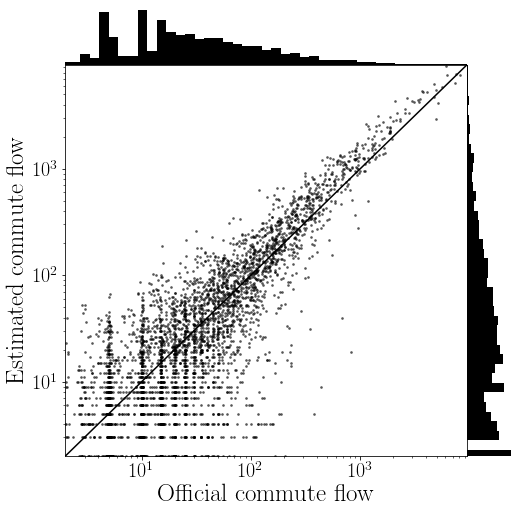

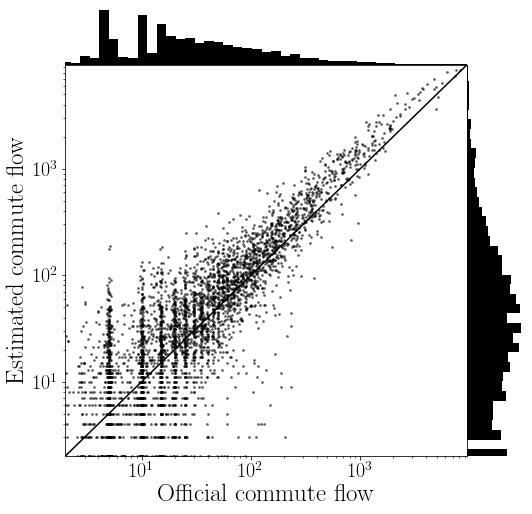

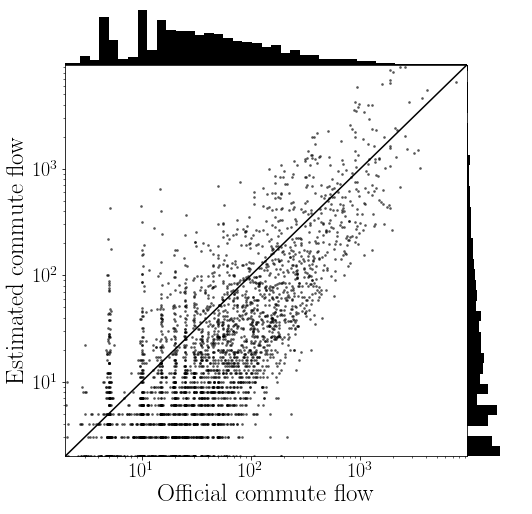

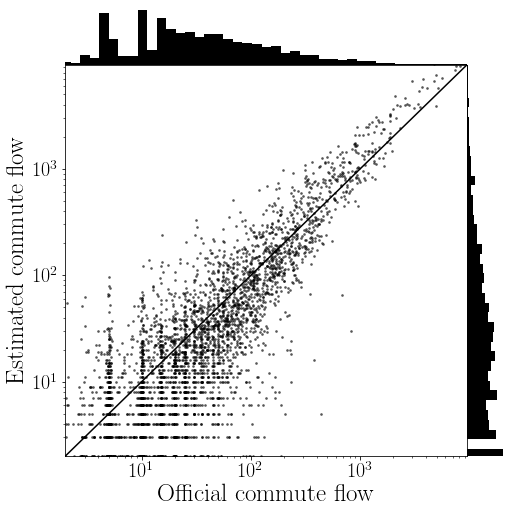

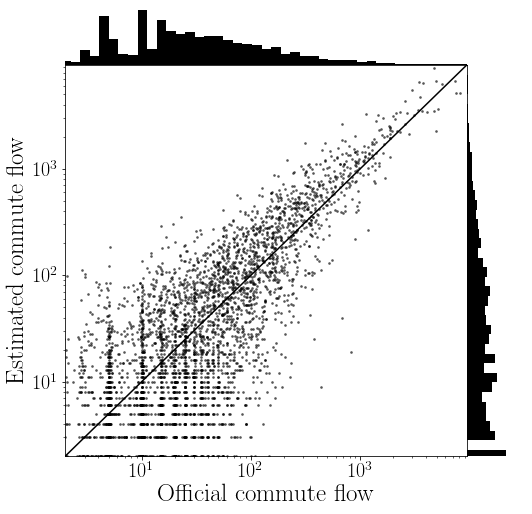

In [204]:


def plot_commute_comparison(X, Y, title=None):
    fig, ax= plt.subplots(figsize=(8,8))
    scatter_with_hist(ax, X, Y, scale='log', color='k', marker_size=3)

    min_val = max(X.min(), Y.min())*2
    max_val = min(X.max(), Y.max())/2
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.plot([min_val,max_val], [min_val,max_val], color='k')

    ax.set_xlabel('Official commute flow')
    ax.set_ylabel('Estimated commute flow')

    outpath = os.path.join(config['outfig_dir'], 'scat_commute_{}.pdf'.format(title))
    plt.savefig(outpath, bbox_inches='tight')
    plt.show()

min_vol = 1
for k in synthpops:
    synthpop_commute_commune = (get_synthpop_commute(k)
                              .groupby(['home_commune', 'work_commune'])
                              .size().rename('vol').reset_index())

    compdf_commute_od = get_compdf_commute_od(synthpop_commute_commune, min_vol)
    plot_commute_comparison(compdf_commute_od['vol_target'], compdf_commute_od['vol_synthpop'],
                           title=k)




In [218]:
def get_mssim(compdf, nb_zones):

    L = 0.0001
    c1 = (0.01*L)**2
    c2 = (0.03*L)**2
    
    compdf['vol2_x'] = compdf['vol_x']**2
    compdf['vol2_y'] = compdf['vol_y']**2
    compdf['vol_xy'] = compdf['vol_x']*compdf['vol_y']
    
    ssimo = compdf.groupby(['o'])[['vol_x', 'vol2_x', 'vol_y', 'vol2_y', 'vol_xy']].sum().reset_index()
    ssimo['mu_x'] = ssimo['vol_x']/nb_zones
    ssimo['s2_x'] = ssimo['vol2_x']/nb_zones - ssimo['mu_x']**2
    ssimo['mu_y'] = ssimo['vol_y']/nb_zones
    ssimo['s2_y'] = ssimo['vol2_y']/nb_zones - ssimo['mu_y']**2
    ssimo['s_xy'] = ssimo['vol_xy']/nb_zones - ssimo['mu_x']*ssimo['mu_y']

    ssimo['ssim'] = (2*ssimo['mu_x']*ssimo['mu_y'] + c1) * (2*ssimo['s_xy'] + c2) / ((ssimo['mu_x']**2 + ssimo['mu_y']**2 + c1) * (ssimo['s2_x'] + ssimo['s2_y'] + c2))
    mssim_o = ssimo['ssim'].sum()/nb_zones**2
    
    ssimd = compdf.groupby(['d'])[['vol_x', 'vol2_x', 'vol_y', 'vol2_y', 'vol_xy']].sum().reset_index()
    ssimd['mu_x'] = ssimd['vol_x']/nb_zones
    ssimd['s2_x'] = ssimd['vol2_x']/nb_zones - ssimd['mu_x']**2
    ssimd['mu_y'] = ssimd['vol_y']/nb_zones
    ssimd['s2_y'] = ssimd['vol2_y']/nb_zones - ssimd['mu_y']**2
    ssimd['s_xy'] = ssimd['vol_xy']/nb_zones - ssimd['mu_x']*ssimd['mu_y']

    ssimd['ssim'] = (2*ssimd['mu_x']*ssimd['mu_y'] + c1) * (2*ssimd['s_xy'] + c2) / ((ssimd['mu_x']**2 + ssimd['mu_y']**2 + c1) * (ssimd['s2_x'] + ssimd['s2_y'] + c2))
    mssim_d = ssimd['ssim'].sum()/nb_zones**2
    
    return mssim_o, mssim_d





def get_kldiv(p, q, eps=1e-30, nb_empty_cells=0):
    pe = p + eps
    norm_factor_p = pe.sum() + nb_empty_cells*eps
    pe = pe/norm_factor_p
    
    qe = q + eps
    norm_factor_q = qe.sum() + nb_empty_cells*eps
    qe = qe/norm_factor_q
    return np.sum(pe * np.log(pe/qe))

def get_R2(X, Y, nb_cells):
    Y_mean = Y.sum()/nb_cells
    
    return 1-np.sum((X-Y)**2)/np.sum((Y-Y_mean)**2)

for k in synthpops:
    synthpop_commute_commune = (get_synthpop_commute(k)
                              .groupby(['home_commune', 'work_commune'])
                              .size().rename('vol').reset_index())

    #compdf_commute_od = (m
    # .merge(synthpop_commute_commune, on=['home_commune', 'work_commune'], 
    #        how='outer', suffixes=('_target', '_synthpop'))
    # .fillna(0)
    #)
#
    #X = compdf_commute_od['vol_synthpop']/compdf_commute_od['vol_synthpop'].sum()
    #Y = compdf_commute_od['vol_target']/compdf_commute_od['vol_target'].sum()
    compdf_commute_od = get_compdf_commute_od(synthpop_commute_commune, min_vol=0)
    
    mssimo, mssimd = get_mssim(compdf_commute_od.rename(columns={'vol_synthpop':'vol_x', 
                                                                 'vol_target':'vol_y',
                                                                 'home_commune':'o',
                                                                 'work_commune':'d'}), 
                                                  nb_zones=nb_commune)
    
    print('{:<3}: kldiv={:.2f}, R2={:.2f}, MSSIM_O={:.10f}, MSSIM_D={:.10f}'.format(k, 
                                       get_kldiv(compdf_commute_od['vol_synthpop'], 
                                                 compdf_commute_od['vol_target'],
                                                 nb_empty_cells=nb_commune**2 - len(compdf_commute_od)),
                                       get_R2(compdf_commute_od['vol_synthpop'], 
                                              compdf_commute_od['vol_target'], 
                                              nb_cells=nb_commune**2), 
                                        mssimo, mssimd))

v1 : kldiv=0.67, R2=0.92, MSSIM_O=0.0067108266, MSSIM_D=0.0064638052
v3 : kldiv=0.90, R2=0.83, MSSIM_O=0.0081284889, MSSIM_D=0.0071774247
v8 : kldiv=0.78, R2=-2.55, MSSIM_O=0.0051260499, MSSIM_D=0.0049555353
v8h2: kldiv=0.55, R2=0.73, MSSIM_O=0.0065826386, MSSIM_D=0.0063826950
v9h6: kldiv=0.85, R2=0.83, MSSIM_O=0.0057547713, MSSIM_D=0.0056310775


### Analysing which flows contribute to the R2 and which to the KL

In [57]:
compdf_commute_od_dict = {}

for k in synthpops.keys():

    synthpop_commute_commune = (get_synthpop_commute(k)
                              .groupby(['home_commune', 'work_commune'])
                              .size().rename('vol').reset_index())
    
    compdf_commute_od = (m
     .merge(synthpop_commute_commune, on=['home_commune', 'work_commune'], 
            how='outer', suffixes=('_target', '_synthpop'))
     .fillna(0)
    )
        
    nb_cells = nb_commune**2
    compdf_commute_od['vol_synthpop_n'] = compdf_commute_od['vol_synthpop']/compdf_commute_od['vol_synthpop'].sum()
    compdf_commute_od['vol_target_n'] = compdf_commute_od['vol_target']/compdf_commute_od['vol_target'].sum()
    
    voltarget_mean = compdf_commute_od['vol_target_n'].sum()/nb_cells
    SStot = ((compdf_commute_od['vol_target_n'] - voltarget_mean)**2).sum()
    compdf_commute_od['squared_error'] = ((compdf_commute_od['vol_synthpop_n'] - compdf_commute_od['vol_target_n'])**2)/SStot
    
    nb_empty_cells = nb_cells - len(compdf_commute_od)
    compdf_commute_od['vol_synthpop_e'] = compdf_commute_od['vol_synthpop']+eps
    norm_factor_p = compdf_commute_od['vol_synthpop_e'].sum() + nb_empty_cells*eps
    compdf_commute_od['vol_synthpop_e'] = compdf_commute_od['vol_synthpop_e']/norm_factor_p
    
    compdf_commute_od['vol_target_e'] = compdf_commute_od['vol_target']+eps
    norm_factor_q = compdf_commute_od['vol_target_e'].sum() + nb_empty_cells*eps
    compdf_commute_od['vol_target_e'] = compdf_commute_od['vol_target_e']/norm_factor_q
    
    compdf_commute_od['kldiv'] = compdf_commute_od['vol_synthpop_e'] * np.log(compdf_commute_od['vol_synthpop_e']/compdf_commute_od['vol_target_e'])
    
    compdf_commute_od_dict[k] = compdf_commute_od

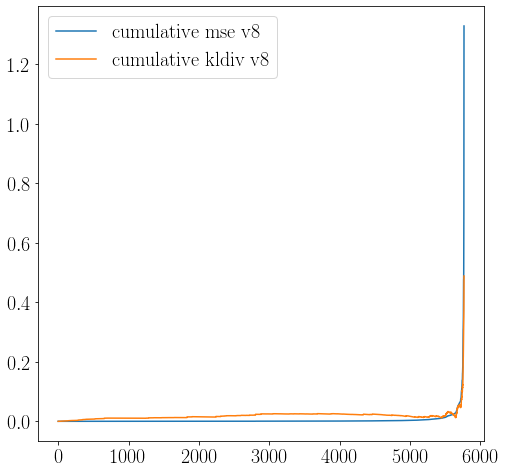

In [246]:
fig, ax= plt.subplots(figsize=(8,8))
k1='v8'
ax.plot(compdf_commute_od_dict[k1].sort_values('vol_target')['squared_error'].values.cumsum(),
          label='cumulative mse {}'.format(k1))

ax.plot(compdf_commute_od_dict[k1].sort_values('vol_target')['kldiv'].values.cumsum(),
          label='cumulative kldiv {}'.format(k1))

#
#k2='v8'
#ax.plot(compdf_commute_od_dict[k2].sort_values('squared_error')['squared_error'].values.cumsum(),
#          label='cumulative mse {}'.format(k2))
#
#ax.plot(compdf_commute_od_dict[k2].sort_values('kldiv')['kldiv'].values.cumsum(),
#          label='cumulative kldiv {}'.format(k2))


plt.legend()

plt.show()


In [264]:
k='v3'
print(k)
print('SSE:')
thres_mse = np.quantile(compdf_commute_od_dict[k]['squared_error'], 0.95)
print('99th quantile: {}'.format(thres_mse))
big_error = compdf_commute_od_dict[k][compdf_commute_od_dict[k]['squared_error']>thres_mse]
print('{} flows contribute a se > {}, total contribution = {}'.format(len(big_error), 
                                                                       thres_mse,
                                                                       big_error['squared_error'].sum()
                                                                      ))


small_error = compdf_commute_od_dict[k][compdf_commute_od_dict[k]['squared_error']<=thres_mse]
print('{} flows contribute a se <= {}, total contribution = {}'.format(len(small_error), 
                                                                        thres_mse,
                                                                       small_error['squared_error'].sum()
                                                                       ))

print('{} flows out of {} ({:.2%}) contribute to {:.2%} of the SSE'.format(
                        len(big_error),
                        len(compdf_commute_od_dict[k]),
                        len(big_error)/len(compdf_commute_od_dict[k]),
                        big_error['squared_error'].sum()/compdf_commute_od_dict[k]['squared_error'].sum()
                                                                          ))

print('\nKLDIV:')
compdf_commute_od_dict[k]['kldiv_abs'] = np.abs(compdf_commute_od_dict[k]['kldiv'])
thres_mse = np.quantile(compdf_commute_od_dict[k]['kldiv_abs'], 0.95)
print('99th quantile: {}'.format(thres_mse))
big_error = compdf_commute_od_dict[k][compdf_commute_od_dict[k]['kldiv_abs']>thres_mse]
print('{} flows contribute a kldiv_abs > {}, total contribution = {}'.format(len(big_error), 
                                                                       thres_mse,
                                                                       big_error['kldiv_abs'].sum()
                                                                      ))


small_error = compdf_commute_od_dict[k][compdf_commute_od_dict[k]['kldiv_abs']<=thres_mse]
print('{} flows contribute a kldiv_abs <= {}, total contribution = {}'.format(len(small_error), 
                                                                        thres_mse,
                                                                       small_error['kldiv_abs'].sum()
                                                                       ))

print('{} flows out of {} ({:.2%}) contribute to {:.2%} of the abs kldiv'.format(
                        len(big_error),
                        len(compdf_commute_od_dict[k]),
                        len(big_error)/len(compdf_commute_od_dict[k]),
                        big_error['kldiv_abs'].sum()/compdf_commute_od_dict[k]['kldiv_abs'].sum()))
                           


v3
SSE:
99th quantile: 5.651499807713404e-06
330 flows contribute a se > 5.651499807713404e-06, total contribution = 0.035453529502860376
6259 flows contribute a se <= 5.651499807713404e-06, total contribution = 0.0018338477690601983
330 flows out of 6589 (5.01%) contribute to 95.08% of the SSE

KLDIV:
99th quantile: 0.00019433221181635544
330 flows contribute a kldiv_abs > 0.00019433221181635544, total contribution = 0.17509032272914268
6259 flows contribute a kldiv_abs <= 0.00019433221181635544, total contribution = 0.14918222253305208
330 flows out of 6589 (5.01%) contribute to 53.99% of the abs kldiv


Saving to /Users/benoit/Desktop/error_contrib.pdf


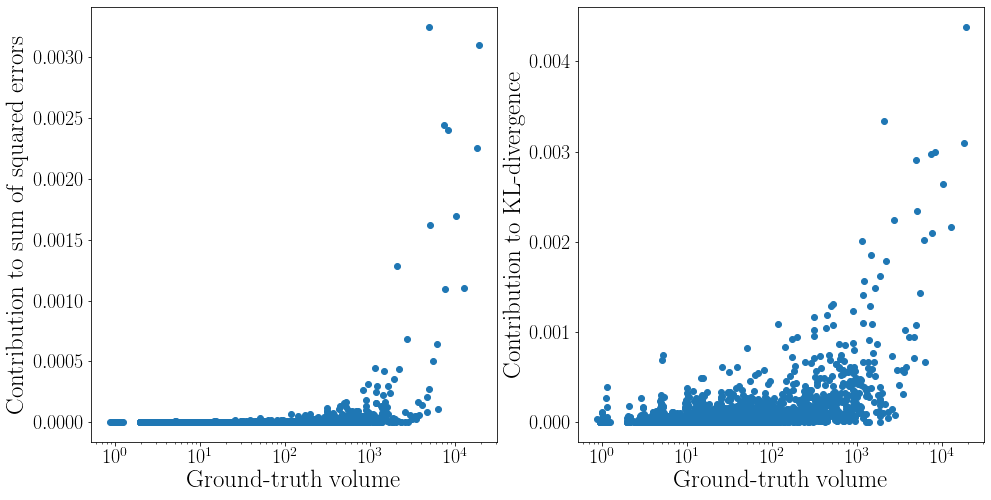

In [266]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
ax = axes[0]
ax.scatter(compdf_commute_od_dict[k]['vol_target'], compdf_commute_od_dict[k]['squared_error'])
ax.set_xlabel('Ground-truth volume')
ax.set_ylabel('Contribution to sum of squared errors')
ax.set_xscale('log')

ax = axes[1]
ax.scatter(compdf_commute_od_dict[k]['vol_target'], compdf_commute_od_dict[k]['kldiv'].abs())
ax.set_xlabel('Ground-truth volume')
ax.set_ylabel('Contribution to KL-divergence')
ax.set_xscale('log')

outpath = os.path.join(config['outfig_dir'], 'error_contrib.pdf')
print('Saving to {}'.format(outpath))
plt.savefig(outpath, bbox_inches='tight')

plt.show()

<a id='eqasim_commute'></a>
## Commute in Eqasim
* [Back to summary](#summary)

In [219]:
c = Chrono('Getting the first workplace / studyplace in agenda...')
resident_trips_df_gr = (resident_trips_df[resident_trips_df['d_purpose'].isin(['work','study'])]
                     .groupby('person_id')
                     ['d'].first().rename('workplace').reset_index())

c.write('Merging with gis to get the work locations...')
eqasim_commute = (
    resident_trips_df_gr
    .merge(perxhome[['person_id', 'socioprofessional_class', 'iris_or_commune']], on='person_id')
    .merge(iris_commune[['iris_or_commune', 'x', 'y', 'commune']], on='iris_or_commune')
    .rename(columns={'x':'hx', 'y':'hy', 'iris_or_commune':'homeplace', 'commune':'home_commune'})
    .merge(iris_commune[['iris_or_commune', 'x', 'y', 'commune']], left_on='workplace', right_on='iris_or_commune')
    .rename(columns={'x':'wx', 'y':'wy', 'commune':'work_commune'})
    .drop(columns=['iris_or_commune'])
)


eqasim_commute_commune = (eqasim_commute
                          .groupby(['home_commune', 'work_commune'])
                          .size().rename('vol').reset_index())
compdf_commute_od = (m
     .merge(eqasim_commute_commune, on=['home_commune', 'work_commune'], 
            how='outer', suffixes=('_target', '_eqasim'))
     .fillna(0))


c.done()

17:01:36	Getting the first workplace / studyplace in agenda...
00:00:00	Merging with gis to get the work locations...
00:00:02	Work complete !


R2 of commute matrix eqasim vs official  : 0.99
KL-divergence of commute matrix eqasim vs official  : 0.20
MSSIM_O of commute matrix eqasim vs official  : 0.0073285783
MSSIM_D of commute matrix eqasim vs official  : 0.0074679134


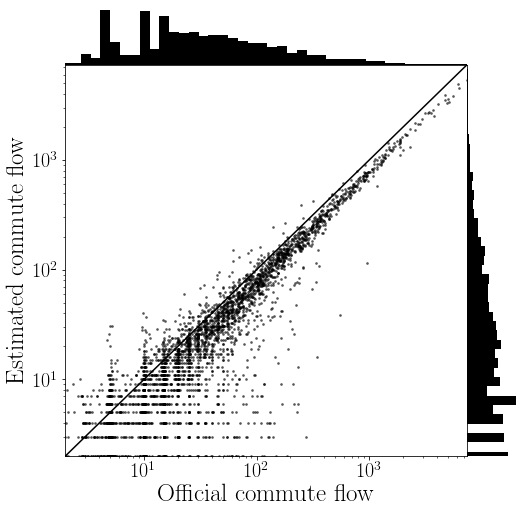

In [220]:

compdf_commute_od['vol_eqasim_norm'] = compdf_commute_od['vol_eqasim']/compdf_commute_od['vol_eqasim'].sum()
compdf_commute_od['vol_target_norm'] = compdf_commute_od['vol_target']/compdf_commute_od['vol_target'].sum()

X = compdf_commute_od['vol_eqasim']/compdf_commute_od['vol_eqasim'].sum()
Y = compdf_commute_od['vol_target']/compdf_commute_od['vol_target'].sum()
print('R2 of commute matrix eqasim vs official  : {:.2f}'.format(get_R2(X, Y, nb_cells=nb_commune**2)))
    
print('KL-divergence of commute matrix eqasim vs official  : {:.2f}'.format(get_kldiv(X, Y)))

mssimo, mssimd = get_mssim(compdf_commute_od.rename(columns={'vol_eqasim_norm':'vol_x', 
                                            'vol_target_norm':'vol_y',
                                            'home_commune':'o',
                                            'work_commune':'d'}), nb_zones = nb_commune
         )

print('MSSIM_O of commute matrix eqasim vs official  : {:.10f}'.format(mssimo))
print('MSSIM_D of commute matrix eqasim vs official  : {:.10f}'.format(mssimd))


                                                 
min_vol=1
compdf_commute_od = compdf_commute_od[(compdf_commute_od['vol_target']>=min_vol)&
                                      (compdf_commute_od['vol_eqasim']>=min_vol)]
X = compdf_commute_od['vol_target']/compdf_commute_od['vol_target'].sum()
Y = compdf_commute_od['vol_eqasim']/compdf_commute_od['vol_eqasim'].sum()
plot_commute_comparison(compdf_commute_od['vol_target'], compdf_commute_od['vol_eqasim'],
                       title='Eqasim')
    
    
    

<a id='lengths'></a>
***
# Lengths of trips
* Getting the distance between centroids of zones, so the graph does not have the usual shape that we find in litterature
* [Back to summary](#summary)

In [69]:
dist_max = 30000
zf['x'] = zf['geometry'].centroid.x
zf['y'] = zf['geometry'].centroid.y

### Getting distance distribution in the HTS
* **D3:** ZF of origin
* **D7:** ZF of destination

In [70]:
# Getting zone to zone distance
zf_path = os.path.join(config['outdata_dir']['path'], config['outdata_dir']['HTS_gis_filtered_filename'])
zf = gpd.read_file(zf_path)
zf['ZF2015_Nouveau_codage'] = zf['ZF2015_Nouveau_codage'].astype(float)
zf['x'] = zf.centroid.x
zf['y'] = zf.centroid.y

zf['cart_key'] = 1
zf_couples = pd.DataFrame(zf[['ZF2015_Nouveau_codage', 'cart_key','x','y']].merge(
                           zf[['ZF2015_Nouveau_codage', 'geometry', 'cart_key','x','y']], 
                           on='cart_key', suffixes=('_o','_d')))

zf_couples['centroid_dist'] = np.sqrt((zf_couples['x_o']-zf_couples['x_d'])**2 + 
                                       (zf_couples['y_o']-zf_couples['y_d'])**2)

zf_couples = zf_couples[['ZF2015_Nouveau_codage_o', 'ZF2015_Nouveau_codage_d', 'centroid_dist']]

#giving in activity chains
for i in range(1, max_chain_len+1):
    egt_with_activity_chains = (egt_with_activity_chains
     .merge(zf_couples, 
            left_on=('dep_{}_zone'.format(i-1), 'dep_{}_zone'.format(i)),
            right_on = ('ZF2015_Nouveau_codage_o', 'ZF2015_Nouveau_codage_d'),
                          how='left'
                         )
     .drop(columns=['ZF2015_Nouveau_codage_o', 'ZF2015_Nouveau_codage_d'])
     .rename(columns={'centroid_dist':'dep_{}_centroid_dist'.format(i)})
    )

In [71]:
length_distrib_egt = pd.concat([
    egt_with_activity_chains.rename(columns={'dep_{}_centroid_dist'.format(i):'dist'})[['dist', 
                                                                                        'scaling_factor_person']]
    for i in range(1, max_chain_len+1)

]).groupby('dist')['scaling_factor_person'].sum().reset_index()

length_distrib_egt['cumsum'] = length_distrib_egt['scaling_factor_person'].cumsum()
length_distrib_egt['cumsum'] = length_distrib_egt['cumsum'] / length_distrib_egt['scaling_factor_person'].sum()
length_distrib_egt

,dist,scaling_factor_person,cumsum
0,0.000000,420664.45268,0.144622
1,70.936186,1146.91861,0.145016
2,132.097100,47.46446,0.145033
3,132.609303,161.80596,0.145088
4,148.032965,367.23150,0.145215
...,...,...,...
12019,23901.487917,186.42596,0.999767
12020,24502.018344,238.79220,0.999849
12021,24504.030905,295.11438,0.999951
12022,24644.058357,44.50857,0.999966


In [72]:
# odm_egt = depl_ori.groupby(['D3', 'D7'])['scaling_factor_person'].sum().reset_index()
# length_distrib_egt = (odm_egt
#                      .merge(zf[['ZF2015_Nouveau_codage', 'x', 'y']],
#                                     left_on='D3', right_on='ZF2015_Nouveau_codage')
#                   .rename(columns={'x':'ox', 'y':'oy'})
#                   .merge(zf[['ZF2015_Nouveau_codage', 'x', 'y']],
#                                     left_on='D7', right_on='ZF2015_Nouveau_codage')
#                   .rename(columns={'x':'dx', 'y':'dy'})
#                      )
# length_distrib_egt['dist'] = np.sqrt((length_distrib_egt['ox']-length_distrib_egt['dx'])**2 + 
#                                  (length_distrib_egt['oy']-length_distrib_egt['dy'])**2)
# length_distrib_egt = length_distrib_egt.groupby('dist')['scaling_factor_person'].sum().reset_index()
# length_distrib_egt['cumsum'] = length_distrib_egt['scaling_factor_person'].cumsum()
# length_distrib_egt['cumsum'] = length_distrib_egt['cumsum']/length_distrib_egt['cumsum'].iloc[-1]
# length_distrib_egt

### Getting distance distribution of any OD matrix
* Works for any OD matrix that has fields `o`, `d`, and `vol`.

In [73]:
def get_length_distrib(odm):
    length_distrib = (odm.merge(iris_commune[['iris_or_commune', 'x', 'y']],
                                    left_on='o', right_on='iris_or_commune')
                  .rename(columns={'x':'ox', 'y':'oy'})
                  .merge(iris_commune[['iris_or_commune', 'x', 'y']],
                                    left_on='d', right_on='iris_or_commune')
                  .rename(columns={'x':'dx', 'y':'dy'})
                     )
    length_distrib['dist'] = np.sqrt((length_distrib['ox']-length_distrib['dx'])**2 + 
                                     (length_distrib['oy']-length_distrib['dy'])**2).clip(upper=dist_max)
    if dist_max not in length_distrib['dist'].values:
        length_distrib = pd.concat([length_distrib, pd.DataFrame({'dist':dist_max, 'vol':0}, index=[len(length_distrib)])])
    length_distrib = length_distrib.groupby('dist')['vol'].sum().reset_index()
    length_distrib['cumsum'] = length_distrib['vol'].cumsum()
    length_distrib['cumsum'] = length_distrib['cumsum']/length_distrib['cumsum'].iloc[-1]
    return length_distrib



### Plotting

Saving to /Users/benoit/Desktop/distance_distrib.pdf


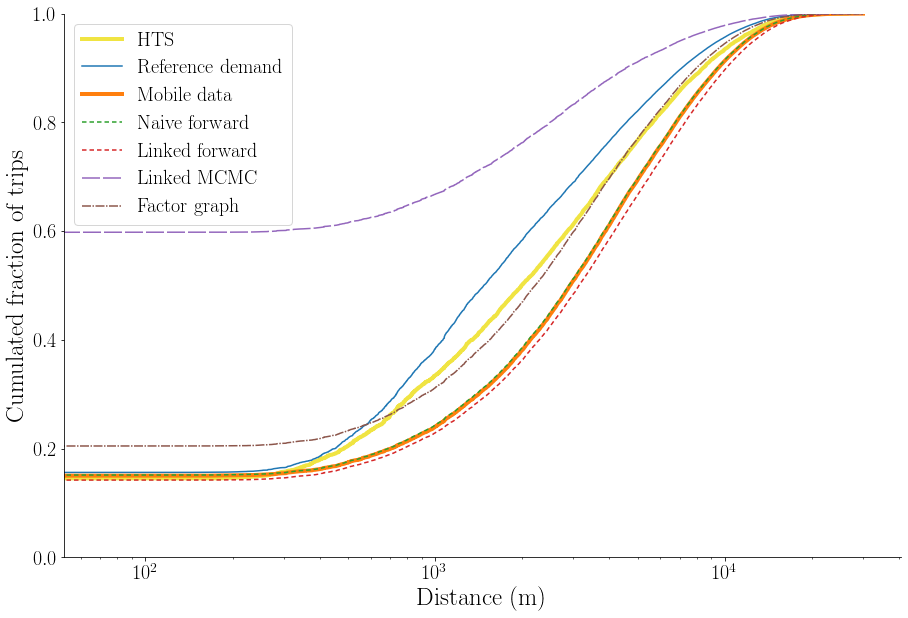

In [74]:
color_dict['orange'] = (241/255, 154/255, 0/255)
import seaborn as sns
sns.reset_orig()
#sns.set_palette('Set3')
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(length_distrib_egt['dist'], length_distrib_egt['cumsum'], 
        c=color_dict['HTS'], linewidth=4, label='HTS')

length_distrib = get_length_distrib(odm_eqasim)
ax.plot(length_distrib['dist'], length_distrib['cumsum'], label='Reference demand')

length_distrib = get_length_distrib(transition_matrix)
ax.plot(length_distrib['dist'], length_distrib['cumsum'], linewidth=4, label='Mobile data')


labels_dicts = {'v1': 'Naive forward', 
                'v3':'Linked forward',
                'v8':'Linked MCMC',
                'v8h2':'Factor graph',
                #'v9h6':'Factor graph dist conditionals',
               }

style_dict={'v1': [3, 2], 
            'v3': [3, 2],
            'v8': [12, 2],
            'v8h2':[6, 1,1,1],
            'v9h6':[6, 2],
               }

color_dict['v1'] = (182/255, 0/255, 74/255)
color_dict['v3'] = (232/255, 0/255, 43/255)
color_dict['v8h'] = (0,0,0)
color_dict['v8h2'] = (147/255, 53/255, 177/255)
color_dict['v9h6'] = (147/255, 53/255, 177/255)

for k, synthpop_od in synthpop_od_dict.items():
    if k in labels_dicts.keys():
        length_distrib = get_length_distrib(synthpop_od)
        
        ax.plot(length_distrib['dist'], length_distrib['cumsum'], 
                label=labels_dicts[k]#, color=color_dict[k]
                #, linestyle='--'
                ,dashes=style_dict[k]
               )

        #line = ax.lines[-1]
        #y = line.get_ydata()[0]
        #x = line.get_xdata()[0]
        #print(x,y)
        #text = ax.annotate(labels_dicts[k],
        #   xy=(x, y),
        #   xytext=(0, 0),
        #   #color=line.get_color(),
        #                   xycoords='axes fraction',
        #   #xycoords=(ax.get_xaxis_transform(), ax.get_yaxis_transform()),
        #      textcoords="offset points"
        #                  )
        
ax.legend()
ax.set_xscale('log')
ax.set_ylim(0, 1)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.set_xlabel('Distance (m)')
ax.set_ylabel('Cumulated fraction of trips')
outpath = os.path.join(config['outfig_dir'], 'distance_distrib.pdf')
print('Saving to {}'.format(outpath))
plt.savefig(outpath, bbox_inches='tight')
plt.show()

In [75]:
distbin_limits = config['distbin_limits']+[np.inf]
dist_bins = [(distbin_limits[i], distbin_limits[i+1]) for i in range(len(distbin_limits)-1)]
dist_bins

[(0, 200),
 (200, 500),
 (500, 1000),
 (1000, 3000),
 (3000, 5000),
 (5000, 7000),
 (7000, 9000),
 (9000, inf)]

In [76]:
bars = []
colors = []
bar_labels = []
from utils.comp_bar import comp_bar

for k, synthpop_od in synthpop_od_dict.items():
    if k in ['v9h6', 'v8h2']:
        length_distrib = get_length_distrib(synthpop_od)
        length_distrib['dist_bin'] = pd.cut(length_distrib['dist'], 
                                            distbin_limits, 
                                            labels=dist_bins, 
                                            include_lowest=True)
        bars += [length_distrib.groupby('dist_bin')['vol'].sum().values]
        if k =='v9h6':
            colors += ['k']
            print(length_distrib.groupby('dist_bin')['vol'].sum())
        else:
            colors += ['r']
        bar_labels+=[k]



length_distrib_egt['dist_bin'] = pd.cut(length_distrib_egt['dist'],
                                        distbin_limits, 
                                        labels=dist_bins, 
                                        include_lowest=True)
bars += [length_distrib_egt.groupby('dist_bin')['scaling_factor_person'].sum()]
colors += [color_dict['HTS']]
bar_labels+=['HTS']


length_distrib = get_length_distrib(odm_eqasim)
length_distrib['dist_bin'] = pd.cut(length_distrib['dist'],
                                    distbin_limits, 
                                    labels=dist_bins, 
                                    include_lowest=True)
bars += [length_distrib.groupby('dist_bin')['vol'].sum()]
colors += ['cyan']
bar_labels+=['Reference demand']


length_distrib = get_length_distrib(transition_matrix)
length_distrib['dist_bin'] = pd.cut(length_distrib['dist'],
                                    distbin_limits, 
                                    labels=dist_bins, 
                                    include_lowest=True)
bars += [length_distrib.groupby('dist_bin')['vol'].sum()]
colors += [color_dict['orange']]
bar_labels+=['Mobile data']

dist_bin
(0, 200)        451320
(200, 500)      119501
(500, 1000)     345831
(1000, 3000)    911456
(3000, 5000)    531349
(5000, 7000)    301720
(7000, 9000)    182580
(9000, inf)     265656
Name: vol, dtype: int64


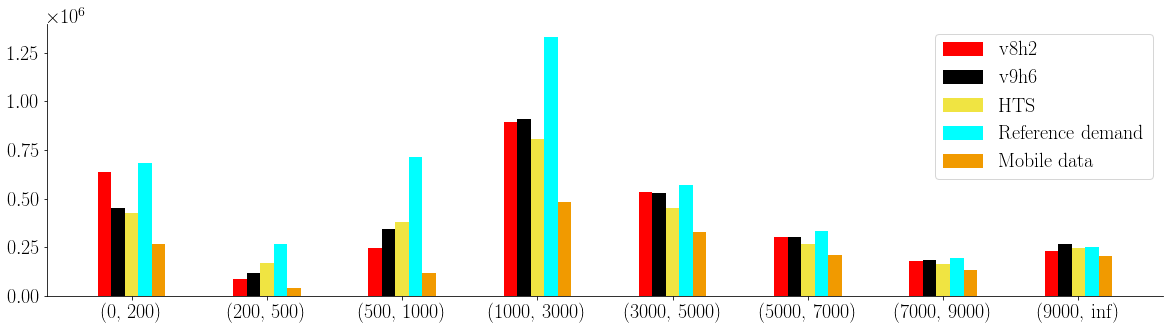

In [77]:
fig, ax = plt.subplots(figsize=(20,5))
comp_bar(ax, bars, colors, bar_labels, normalize=False, labels=False, width=0.1)
ax.set_xticks(range(len(dist_bins)), labels=dist_bins)
plt.show()

In [78]:
synthpop = synthpops['v9h6']
Y_distbins = np.zeros(len(dist_bins))

for d in range(len(Y_distbins)):
    for i in range(1, max_chain_len+1):
        Y_distbins[d] += (synthpop['dep_{}_distbin'.format(i)]==d).sum()

Y_distbins

array([ 73127., 324797., 633053., 844441., 459155., 295600., 185640.,
       293600.])

In [79]:
# distance bins marginals
X_distbins = np.zeros(len(dist_bins))
for b in range(len(Y_distbins)):
    for i in range(1, max_chain_len+1):
        X_distbins[b] += egt_with_activity_chains[egt_with_activity_chains['dep_{}_distbin'.format(i)]==b]['scaling_factor_person'].sum()

X_distbins

array([424715.23599, 170126.16927, 377564.60432, 808358.11276,
       449268.07041, 267525.42071, 164849.68017, 246307.0976 ])

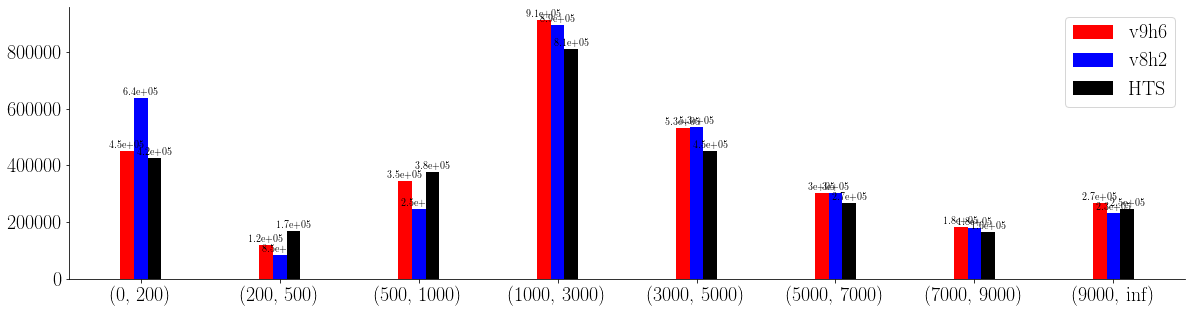

In [80]:

    
bars = []
colors = []
bar_labels = []

k = 'v9h6'
synthpop_od = synthpop_od_dict[k]
length_distrib = get_length_distrib(synthpop_od)
length_distrib['dist_bin'] = pd.cut(length_distrib['dist'], 
                                    distbin_limits, 
                                    labels=dist_bins, 
                                    include_lowest=True)
Y_distbin_alt = length_distrib.groupby('dist_bin')['vol'].sum().values
bars += [Y_distbin_alt]
colors += ['r']
bar_labels+=['v9h6']


k = 'v8h2'
synthpop_od = synthpop_od_dict[k]
length_distrib = get_length_distrib(synthpop_od)
length_distrib['dist_bin'] = pd.cut(length_distrib['dist'], 
                                    distbin_limits, 
                                    labels=dist_bins, 
                                    include_lowest=True)
Y_distbin_alt8 = length_distrib.groupby('dist_bin')['vol'].sum().values
bars += [Y_distbin_alt8]
colors += ['b']
bar_labels+=['v8h2']


length_distrib_egt['dist_bin'] = pd.cut(length_distrib_egt['dist'],
                                        distbin_limits, 
                                        labels=dist_bins, 
                                        include_lowest=True)
bars += [length_distrib_egt.groupby('dist_bin')['scaling_factor_person'].sum().values]
colors += ['k']
bar_labels+=['HTS']

fig, ax = plt.subplots(figsize=(20,5))
comp_bar(ax, bars, colors, bar_labels, normalize=False, labels=True, width=0.1)
ax.set_xticks(range(len(dist_bins)), labels=dist_bins)
plt.show()

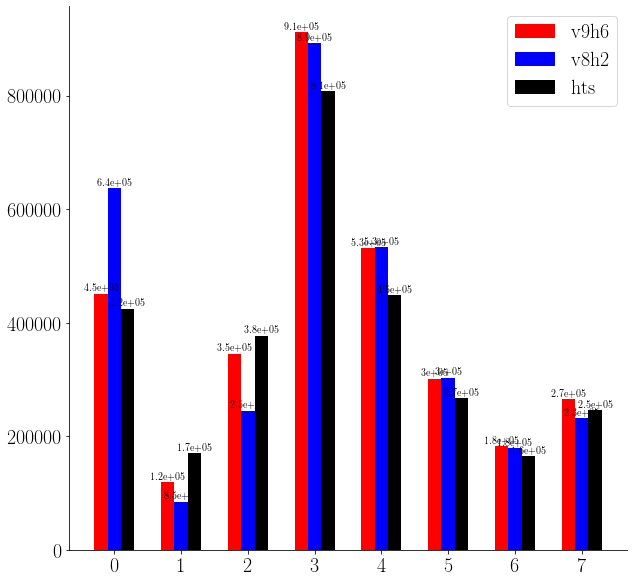

In [81]:
fig, ax = plt.subplots(figsize=(10,10))
comp_bar(ax, bars = [ 
                     Y_distbin_alt,
                     Y_distbin_alt8,
    X_distbins,
                    ], colors=['r','b','k',], bar_labels=['v9h6','v8h2','hts',], normalize=False)

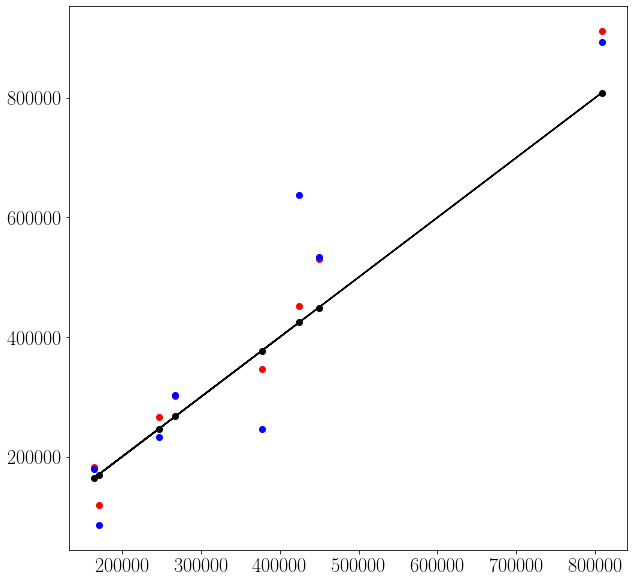

In [82]:
fig, ax = plt.subplots(figsize=(10,10))

#ax.scatter(X_distbins, Y_distbins)
ax.scatter(X_distbins, Y_distbin_alt, color='r')
ax.scatter(X_distbins, Y_distbin_alt8, color='b')
ax.plot(X_distbins, X_distbins, c='k', marker='o')

plt.show()



<a id='profiles'></a>
***
# Number of trips per timestep
* [Back to summary](#summary)

In [83]:
color_dict = {
    'census' : (0,0,0),
    'synthpop' : (182/255,0/255,74/255),
    'synthpop_pre_ipu' : (88/255, 35/255, 128/255),
    'EMD' : (170/255, 204/255, 0/255),
    #'HTS' : (0/255, 158/255, 15/255),  # Green Wong for colorblindsafe palette 
    'HTS' : (240/255, 228/255, 66/255),  # Modified Yellow Wong for colorblindsafe palette 
    'orange' : (241/255, 154/255, 0/255),
    'eqasim' : (48/255, 190/255, 242/255)
}


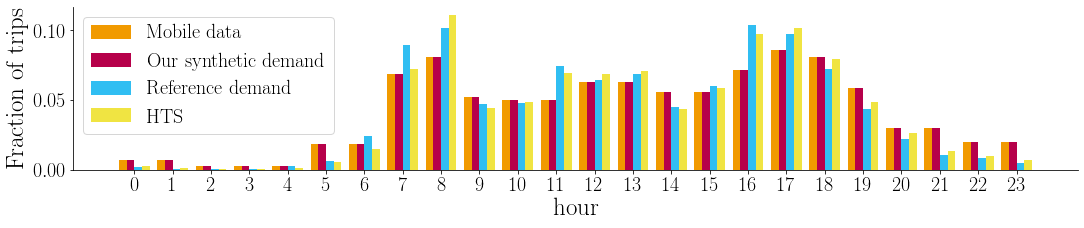

In [84]:

k=list(synthpops.keys())[-1]
synthpop_trips = synthpop_trips_dict[k]
synthpop_profile = synthpop_trips.groupby('t').size().values

hours, synthpop_profile = redistribute_hourly(timesteps.astype(int), synthpop_profile)

hours, odm_profile = redistribute_hourly(timesteps.astype(int), trips_by_hour_odm['vol'])
odm_profile *= synthpop_profile.sum()/odm_profile.sum()

depl_ori['hour'] = depl_ori['D4'].str[:2].astype(int)%24
emd_profile = depl_ori.groupby('hour')['scaling_factor_person'].sum().values


eqasim_profile = resident_activities_df.groupby('hour').size().values


fig, ax = plt.subplots(figsize=(18,3))
comp_bar(ax, labels=False, normalize=True,
         bars = [odm_profile, synthpop_profile, eqasim_profile, emd_profile],
         bar_labels = ['Mobile data', 'Our synthetic demand', 'Reference demand', 'HTS'],
         colors = [color_dict['orange'], color_dict['synthpop'], color_dict['eqasim'], color_dict['HTS']],
         width=0.2
        )

ax.set_ylabel('Fraction of trips')
ax.set_xlabel('hour')
ax.set_xticks(np.arange(24), np.arange(24))

outpath = os.path.join(config['outfig_dir'], 'trips_by_timestep_eval.pdf')
plt.savefig(outpath, bbox_inches='tight')

plt.show()

<a id='agenda_pop'></a>
# Agenda popularity
* [Back to summary](#summary)

In [85]:
import scipy.integrate as integrate

<a id='synthpopagendapop'></a>
## Popularities in synthpop
* [Back to summary](#summary)

In [86]:
synthpop = synthpops['v1']
agenda_cols = ['dep_{}_{}'.format(i, carac) for i in range(1,max_chain_len+1) 
               for carac in ['mode', 'motif', 'time']] + ['chain_len']


In [87]:
c = Chrono('Getting popularity of agendas in synthpop...')
nb_people_per_group_synthpop = (synthpop
                       .groupby(agenda_cols, dropna=False)
                       .size()
                       .sort_values(ascending=True)
                        .reset_index()
                       .rename(columns={0:'nb_people'}))

Y_synthpop = np.concatenate([[0], nb_people_per_group_synthpop['nb_people'].values.cumsum()])
Y_synthpop = Y_synthpop/Y_synthpop[-1]
X_synthpop = np.linspace(0,1,len(Y_synthpop))
c.write('Computing Gini index of popularity of agendas in synthpop...')
G_synthpop = 1-2*integrate.trapezoid(Y_synthpop, X_synthpop)


11:55:03	Getting popularity of agendas in synthpop...
00:00:01	Computing Gini index of popularity of agendas in synthpop...


<a id='eqasimagendapop'></a>
## Popularities in Eqasim
* [Back to summary](#summary)

In [88]:
eqasim_per_in_zone = perxhome[~perxhome['iris_or_commune'].isna()]

In [89]:
# fitting seconds to timesteps
trips['t'] = timesteps[np.searchsorted(timesteps, trips['departure_time']//3600, side='right')-1]


In [90]:
trips['purpose'] = trips['following_purpose'].replace({'shop':3, 
                                                       'home':0, 
                                                       'leisure':4, 
                                                       'other':4, 
                                                       'education':2, 
                                                       'work':1
                                                      })

trips['mode'] = trips['mode'].replace({'car':2, 
                                       'walk':0, 
                                       'car_passenger':2, 
                                       'pt':3, 
                                       'bike':1
                                                      })


In [91]:
# 00:04:00
c = Chrono('agg...')
trips_agg = trips.groupby('person_id')[['t', 'mode', 'purpose']].agg(tuple)
c.write('max chain len in eqasim: {}'.format(trips_agg['t'].str.len().max()))
c.done()


11:55:34	agg...
00:05:08	max chain len in eqasim: 20
00:05:08	Work complete !


In [92]:
trips_agg_per_in_zone = trips_agg.merge(eqasim_per_in_zone[['person_id']], on='person_id', how='right')

In [93]:
eqasim_agenda_counts = (trips_agg_per_in_zone.groupby(['t', 'mode','purpose'], dropna=False)
                        .size().rename('vol')
                        .sort_values(ascending=True)
                        .reset_index()
                       )

In [94]:
for i in range(1, max_chain_len+1):
    eqasim_agenda_counts['dep_{}_time'.format(i)] = eqasim_agenda_counts['t'].str[i-1].astype(float)
    eqasim_agenda_counts['dep_{}_mode'.format(i)] = eqasim_agenda_counts['mode'].str[i-1].astype(float)
    eqasim_agenda_counts['dep_{}_motif'.format(i)] = eqasim_agenda_counts['purpose'].str[i-1].astype(float)
    
time_cols = ['dep_{}_time'.format(i) for i in range(1,max_chain_len+1)]
eqasim_agenda_counts['chain_len'] = (~eqasim_agenda_counts[time_cols].isna()).sum(axis=1)

In [95]:

Y_eqasim = np.concatenate([[0], eqasim_agenda_counts['vol'].values.cumsum()])
Y_eqasim = Y_eqasim/Y_eqasim[-1]
X_eqasim = np.linspace(0,1,len(Y_eqasim))
c.write('Computing Gini index of popularity of agendas in EGT...')
G_eqasim = 1-2*integrate.trapezoid(Y_eqasim, X_eqasim)
c.done()

00:05:14	Computing Gini index of popularity of agendas in EGT...
00:05:14	Work complete !


<a id='htsagendapop'></a>
## Popularities in HTS
* [Back to summary](#summary)

In [96]:


c.write('Getting popularity of agendas in EGT...')

nb_people_per_group_egt = (egt_with_activity_chains
                        .groupby(agenda_cols, dropna=False)
                       ['scaling_factor_person'].agg(['sum', len])
                           .rename(columns={'sum':'scaling_factor_person', 'len':'nb_egt_respondants'})
                       .sort_values(by='scaling_factor_person', ascending=True)
                        .reset_index()
)
Y_egt = np.concatenate([[0], nb_people_per_group_egt['scaling_factor_person'].values.cumsum()])
Y_egt = Y_egt/Y_egt[-1]
X_egt = np.linspace(0,1,len(Y_egt))
c.write('Computing Gini index of popularity of agendas in EGT...')
G_egt = 1-2*integrate.trapezoid(Y_egt, X_egt)

c.done()

00:05:14	Getting popularity of agendas in EGT...
00:05:14	Computing Gini index of popularity of agendas in EGT...
00:05:14	Work complete !


<a id='giniagendapop'></a>
## Plotting
* [Back to summary](#summary)

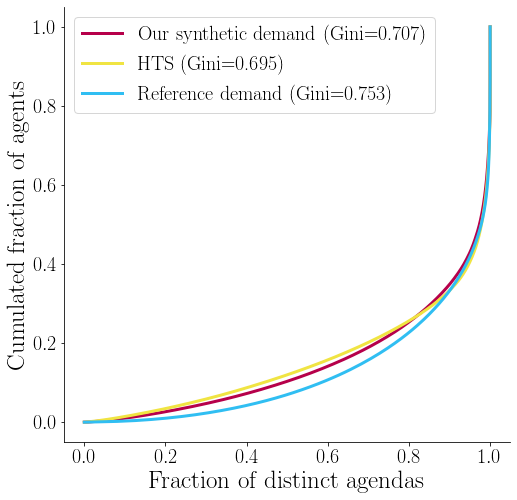

In [97]:



fig, ax = plt.subplots(figsize=(8,8))

ax.plot(X_synthpop, Y_synthpop,
        label='Our synthetic demand (Gini={:.3f})'.format(G_synthpop),
        color=color_dict['synthpop'], linewidth=3)

ax.plot(X_egt, Y_egt,
        label='HTS (Gini={:.3f})'.format(G_egt),
        color=color_dict['HTS'], linewidth=3)

ax.plot(X_eqasim, Y_eqasim,
        label='Reference demand (Gini={:.3f})'.format(G_eqasim),
        color=color_dict['eqasim'], linewidth=3)

ax.set_ylabel('Cumulated fraction of agents')
ax.set_xlabel('Fraction of distinct agendas')
ax.legend()
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

outpath = os.path.join(config['outfig_dir'], 'agendas_popularity_gini.pdf')
plt.savefig(outpath, bbox_inches='tight')

plt.show()

<a id='plotagendapop'></a>
## Scatter plot of agenda popularity
* [Back to summary](#summary)

In [98]:
def scat_agenda_popularity(ax, agenda_vols, color, s=None):
    ax.scatter(agenda_vols['scaling_factor_person'], agenda_vols['vol'], 
               alpha=0.3, color=color, s=s)
    
    min_val = min(agenda_vols['scaling_factor_person'].min(), agenda_vols['vol'].min())
    max_val = max(agenda_vols['scaling_factor_person'].max(), agenda_vols['vol'].max())
    
    ax.plot([min_val, max_val], [min_val, max_val], color='k')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)


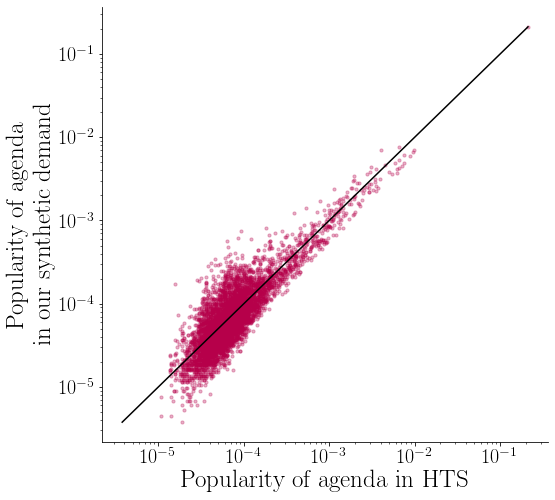

In [99]:
fig, ax = plt.subplots(figsize=(8, 8))

agenda_vols = nb_people_per_group_egt.merge(nb_people_per_group_synthpop, on=agenda_cols, how='outer')
agenda_vols['scaling_factor_person'] = agenda_vols['scaling_factor_person'].fillna(0)/agenda_vols['scaling_factor_person'].sum()
agenda_vols['vol'] = agenda_vols['nb_people'].fillna(0)/agenda_vols['nb_people'].sum()
scat_agenda_popularity(ax, agenda_vols, color=color_dict['synthpop'], s=10)
ax.set_xlabel('Popularity of agenda in HTS')
ax.set_ylabel('Popularity of agenda \nin our synthetic demand')

outpath = os.path.join(config['outfig_dir'], 'agendas_popularity.pdf')
plt.savefig(outpath, bbox_inches='tight')

plt.show()

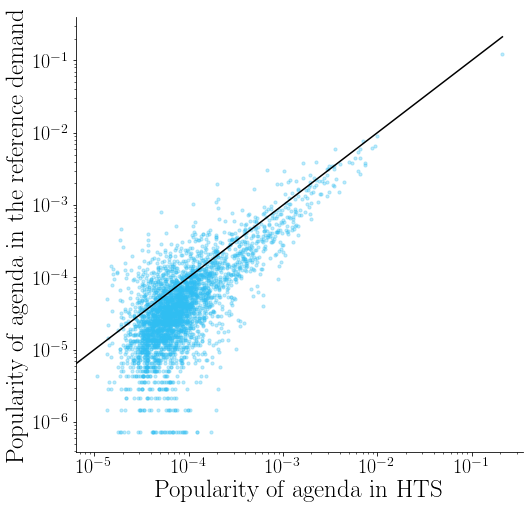

In [100]:
fig, ax = plt.subplots(figsize=(8, 8))

agenda_vols = nb_people_per_group_egt.merge(eqasim_agenda_counts, on=agenda_cols, how='outer')
agenda_vols['scaling_factor_person'] = agenda_vols['scaling_factor_person'].fillna(0)/agenda_vols['scaling_factor_person'].sum()
agenda_vols['vol'] = agenda_vols['vol'].fillna(0)/agenda_vols['vol'].sum()
scat_agenda_popularity(ax, agenda_vols, color=color_dict['eqasim'], s=10)
ax.set_xlabel('Popularity of agenda in HTS')
ax.set_ylabel('Popularity of agenda in the reference demand')

#fig.tight_layout(pad=3.0)
plt.show()

<a id='reports'></a>
# Comparing to official results
* [Back to summary](#summary)

## Chain len male vs female

In [101]:
chain_len = trips.groupby('person_id').size().rename('chain_len').reset_index()
per = per.merge(chain_len, on='person_id')
per.groupby('sex')['chain_len'].mean().reset_index()

,sex,chain_len
0,female,3.950950
1,male,3.775465


<a id='egt_res'></a>
# Recreating EGT results
* [Back to summary](#summary)

<a id='radial_trips'></a>
## Radial trips
* [Back to summary](#summary)

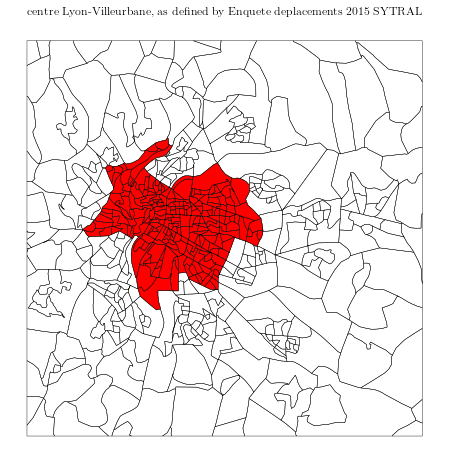

In [102]:
communes_centre = ['69381',
               '69382',
               '69383',
               '69384',
               '69385',
               '69386',
               '69387',
               '69388',
               '69389',
               '69266',]

iris_commune_centre = iris_commune[iris_commune['commune'].isin(communes_centre)]
zone_centre = iris_commune_centre['iris_or_commune'].unique()

fig,ax = plt.subplots(figsize=(8,8))
iris_commune.boundary.plot(ax=ax, edgecolor='k', linewidth=0.4)
iris_commune_centre.plot(ax=ax, color='r')
ax.axis(False)
ax.set_title('centre Lyon-Villeurbane, as defined by Enquete deplacements 2015 SYTRAL ')
plt.show()

In [103]:
zf_centre = zf[zf['DepCom'].isin(communes_centre)]
zf_centre_list = zf_centre['ZF2015_Nouveau_codage'].unique()

print('Proportion of radial trips:')

depl_egt_raw['is_radial'] = depl_egt_raw['D3'].isin(zf_centre_list) ^ depl_egt_raw['D7'].isin(zf_centre_list) # XOR
radial_frac_egt_raw = (depl_egt_raw['is_radial']*depl_egt_raw['COE1']).sum() / depl_egt_raw['COE1'].sum()
print('egt raw:\t{:.2f}%'.format(100*radial_frac_egt_raw))


depl_ori['is_radial'] = depl_ori['D3'].isin(zf_centre_list) ^ depl_ori['D7'].isin(zf_centre_list) # XOR
radial_frac_egt = (depl_ori['is_radial']*depl_ori['scaling_factor_person']).sum() / depl_ori['scaling_factor_person'].sum()
print('egt:    \t{:.2f}%'.format(100*radial_frac_egt))


odm_eqasim['is_radial'] = odm_eqasim['o'].isin(zone_centre) ^ odm_eqasim['d'].isin(zone_centre)
radial_frac_eqasim = (odm_eqasim['is_radial']*odm_eqasim['vol']).sum() / odm_eqasim['vol'].sum()
print('eqasim:  \t{:.2f}%'.format(100*radial_frac_eqasim))


for k, synthpop_trips in synthpop_trips_dict.items():
    synthpop_trips['is_radial'] = synthpop_trips['o'].isin(zone_centre) ^ synthpop_trips['d'].isin(zone_centre)
    radial_frac_synthpop = synthpop_trips['is_radial'].mean()
    print('synthpop {}:\t{:.2f}%'.format(k, 100*radial_frac_synthpop))

Proportion of radial trips:
egt raw:	14.10%
egt:    	16.97%
eqasim:  	18.80%
synthpop v1:	26.39%
synthpop v3:	27.86%
synthpop v8:	7.90%
synthpop v8h2:	21.49%
synthpop v9h6:	23.76%


### Transport mode of radial trips
* <font color='red'> Need to use the true **trips** dataset of eqasim to get the modes </font>

In [104]:
radial_mode_synthpop = (synthpop_trips[synthpop_trips['is_radial']]
                        .groupby('mode').size().rename('vol').reset_index())
radial_mode_synthpop['vol'] = radial_mode_synthpop['vol']/radial_mode_synthpop['vol'].sum()
radial_mode_synthpop

,mode,vol
0,0.0,0.078445
1,1.0,0.018711
2,2.0,0.597022
3,3.0,0.305822


<a id='socioeco_comp_radial_trips'></a>
### Socio eco comp of radial trips
* [Back to summary](#summary)


In [105]:
k = list(synthpop_trips_dict.keys())[-1]
synthpop_trips = synthpop_trips_dict[k]
synthpop = synthpops[k]

In [106]:
radial_comp_synthpop = (synthpop_trips
                  .merge(synthpop[['agent_id', 'occupation']], left_on='person_id', right_on='agent_id')
                 .groupby(['is_radial', 'occupation'])
                        .size().rename('vol').reset_index()
                 )
radial_comp_synthpop['vol'] = radial_comp_synthpop['vol']/radial_comp_synthpop.groupby('is_radial')['vol'].transform('sum')

c.write('Arranging modalities to be compatible with the other pops...')
radial_comp_synthpop['occupation'] = radial_comp_synthpop['occupation'].replace({8:0})
radial_comp_synthpop = (radial_comp_synthpop.groupby(['is_radial', 'occupation'])
                                  .sum().reset_index())

radial_comp_synthpop[radial_comp_synthpop['is_radial']]

00:05:30	Arranging modalities to be compatible with the other pops...


,is_radial,occupation,vol
8,True,0,0.264618
9,True,1,0.000185
10,True,2,0.023992
11,True,3,0.114422
12,True,4,0.125078
13,True,5,0.117678
14,True,6,0.071215
15,True,7,0.282811


In [107]:
depl_ori['id_per'] = depl_ori['id_per'].astype(float)

In [108]:
# scaling_factor_person has already been added to depl_ori
radial_comp_egt = (depl_ori
                  .merge(egt[['id_per', 'occupation']], on='id_per')
                  .groupby(['is_radial', 'occupation'])
                   ['scaling_factor_person'].sum()
                  .rename('vol').reset_index()
                 )
radial_comp_egt['vol'] = radial_comp_egt['vol']/radial_comp_egt.groupby('is_radial')['vol'].transform('sum')

radial_comp_egt['occupation'] = radial_comp_egt['occupation'].replace({8:0})
radial_comp_egt = (radial_comp_egt.groupby(['is_radial', 'occupation'])
                                  .sum().reset_index())


radial_comp_egt[radial_comp_egt['is_radial']]

,is_radial,occupation,vol
8,True,0.0,0.189198
9,True,1.0,0.000126
10,True,2.0,0.026319
11,True,3.0,0.191869
12,True,4.0,0.156523
13,True,5.0,0.140752
14,True,6.0,0.083470
15,True,7.0,0.211745


In [109]:
resident_trips_df['is_radial'] = resident_trips_df['o'].isin(zone_centre) ^ resident_trips_df['d'].isin(zone_centre)

radial_comp_eqasim = (resident_trips_df
.merge(per[['person_id', 'socioprofessional_class']], on='person_id')
.groupby(['is_radial', 'socioprofessional_class'])
.size()
.rename('vol').reset_index())
radial_comp_eqasim['vol'] = radial_comp_eqasim['vol']/radial_comp_eqasim.groupby('is_radial')['vol'].transform('sum')


c.write('Arranging modalities to be compatible with the other pops...')
radial_comp_eqasim['socioprofessional_class'] = radial_comp_eqasim['socioprofessional_class'].replace({8:0, 9:0})
radial_comp_eqasim = radial_comp_eqasim.rename(columns={'socioprofessional_class':'occupation'})
radial_comp_eqasim = radial_comp_eqasim.sort_values('occupation')

radial_comp_eqasim[radial_comp_eqasim['is_radial']]
c.done()

00:05:34	Arranging modalities to be compatible with the other pops...
00:05:34	Work complete !


In [110]:
def get_kldiv(p, q, eps=1e-9):
    pe = p + eps
    qe = q + eps
    return np.sum(pe + np.log(pe/qe))

print(get_kldiv(radial_comp_eqasim[(radial_comp_eqasim['is_radial'])
                                  &(radial_comp_eqasim['occupation']!=1)]['vol'].values,
            radial_comp_egt[radial_comp_egt['is_radial']]['vol'].values))

print(get_kldiv(radial_comp_synthpop[(radial_comp_synthpop['is_radial'])
                                    &(radial_comp_synthpop['occupation']!=1)]['vol'].values,
            radial_comp_egt[radial_comp_egt['is_radial']]['vol'].values))

ValueError: operands could not be broadcast together with shapes (7,) (8,) 

<a id='commute_wrt_profession'></a>
## Commute distance wrt profession
* Bit difficult to compute this for egt raw as it requires reducting the purposes (~100 distinct purposes in egt raw).
* Also the result of reducting the purposes is `depl_ori`, already used for egt_filtered so..
* [Back to summary](#summary)

|modality| occupation                                  | socioprofessional_class / PCSC              |
|--------|---------------------------------------------|---------------------------------------------|
|**0**   | inactif, chômeur                            | Non réponse                                 |
|**1**   | Agriculteurs exploitants                    | Agriculteurs exploitants                    |
|**2**   | Artisans, commerçants et chefs d'entreprise | Artisans, commerçants et chefs d'entreprise |
|**3**   | Cadres                                      | Cadres                                      |
|**4**   | Professions Intermédiaires                  | Professions Intermédiaires                  |
|**5**   | Employés                                    | Employés                                    |
|**6**   | Ouvriers                                    | Ouvriers                                    |
|**7**   | Élèves, étudiants                           | Élèves, étudiants                           |
|**8**   | Retraité                                    | Chômeurs n'ayant jamais travaillé           |
|**9**   |                                             | Autres inactifs n'ayant jamais travaillé    |                 


In [ ]:
dist_bins = [0, 2000, 5000, np.inf]


In [ ]:
egt['dist_bin'] = pd.cut(egt['L2_dist_commute'], dist_bins, 
                         labels=range(len(dist_bins)-1),
                        include_lowest=True)
egt_commute_dist = egt.groupby(['dist_bin', 'occupation'])['scaling_factor_person'].sum().reset_index()


egt_commute_dist['occupation'] = egt_commute_dist['occupation'].replace({8:0})
egt_commute_dist = (egt_commute_dist.groupby(['dist_bin', 'occupation'])
                             .sum().reset_index())

egt_commute_dist

In [ ]:


k = list(synthpop_trips_dict.keys())[-1]

synthpop_commute = get_synthpop_commute(k)

# Binning distances...
synthpop_commute['dist_bin'] = pd.cut(synthpop_commute['l2_commute'], dist_bins, 
                                      labels=range(len(dist_bins)-1),
                                     include_lowest=True)
    
synthpop_commute_dist = synthpop_commute.groupby(['dist_bin', 'occupation']).size().rename('vol').reset_index()

synthpop_commute_dist

In [ ]:

c = Chrono('Getting commute distances in eqasim commute...')
eqasim_commute['l2_commute'] = np.sqrt((eqasim_commute['hx']-eqasim_commute['wx'])**2 + 
                                       (eqasim_commute['hy']-eqasim_commute['wy'])**2)

c.write('Binning distances...')
eqasim_commute['dist_bin'] = pd.cut(eqasim_commute['l2_commute'], 
                                    dist_bins, labels=range(len(dist_bins)-1),
                                   include_lowest=True)
eqasim_commute_dist = (eqasim_commute
                       .groupby(['dist_bin', 'socioprofessional_class'])
                       .size().reset_index()
                       .rename(columns={'socioprofessional_class':'occupation', 0:'vol'}))

c.write('Arranging modalities to be compatible with the other pops...')
eqasim_commute_dist = eqasim_commute_dist

c.done()

eqasim_commute_dist

In [ ]:
commute_comp = (eqasim_commute_dist
 .merge(synthpop_commute_dist, on=['dist_bin', 'occupation'])
 .merge(egt_commute_dist, on=['dist_bin', 'occupation'])
.rename(columns={'vol_x':'vol_eqasim', 'vol_y':'vol_synthpop', 'scaling_factor_person':'vol_egt'}))

occupations = [
    #'inactif, chômeur',
    #'Agriculteurs exploitants',
    'Artisans, commerçants et chefs d\'entreprise',
    'Cadres',
    'Professions Intermédiaires',
    'Employés',
    'Ouvriers',
    'Élèves, étudiants',
    #'Retraité',
]

for target_occupation, occupation in enumerate(occupations):
    fig, ax = plt.subplots(figsize=(10,3))
    comp_bar(ax=ax, 
         EMD=commute_comp[commute_comp['occupation']==target_occupation]['vol_egt'],
         synthpop=commute_comp[commute_comp['occupation']==target_occupation]['vol_synthpop'],
         eqasim=commute_comp[commute_comp['occupation']==target_occupation]['vol_eqasim'],
      )
    ax.set_xlabel(occupation)
    ax.set_xticks([0,1,2], labels=list(zip(dist_bins[:-1], dist_bins[1:])))

<a id='recreating_not_commute'></a>
## Repartition of not-commute trips
* [Back to summary](#summary)



In [ ]:
dist_bins = [0, 1000, 2000, 3000, 5000, np.inf]


In [ ]:
synthpop_trips['is_commute'] = ((synthpop_trips['o_purpose'].isin([1,2]) & (synthpop_trips['d_purpose']==0)) |
                                ((synthpop_trips['o_purpose']==0) & synthpop_trips['d_purpose'].isin([1,2])))

synthpop_trips_xy = (synthpop_trips
.merge(iris_commune[['iris_or_commune', 'x', 'y']],left_on='o', right_on='iris_or_commune')
.rename(columns={'x':'ox', 'y':'oy'})
.drop(columns=['iris_or_commune'])
.merge(iris_commune[['iris_or_commune', 'x', 'y']], left_on='d', right_on='iris_or_commune')
.rename(columns={'x':'dx', 'y':'dy'})
.drop(columns=['iris_or_commune'])
)
synthpop_trips_xy['l2'] = np.sqrt((synthpop_trips_xy['ox']-synthpop_trips_xy['dx'])**2 + 
                               (synthpop_trips_xy['oy']-synthpop_trips_xy['dy'])**2)

synthpop_trips_xy['dist_bin'] = pd.cut(synthpop_trips_xy['l2'], dist_bins, 
                                       labels=range(len(dist_bins)-1), include_lowest=True)
synthpop_trips_xy = (synthpop_trips_xy[~synthpop_trips_xy['is_commute']]
                     .groupby('dist_bin').size().rename('vol').reset_index())


In [ ]:
resident_trips_df['is_commute']=((resident_trips_df['o_purpose'].isin([1,2])&(resident_trips_df['d_purpose']==0))|
                                ((resident_trips_df['o_purpose']==0) & resident_trips_df['d_purpose'].isin([1,2])))

eqasim_trips_xy = (
    resident_trips_df
    .merge(iris_commune[['iris_or_commune', 'x', 'y']],left_on='o', right_on='iris_or_commune')
    .rename(columns={'x':'ox', 'y':'oy'})
    .drop(columns=['iris_or_commune'])
    .merge(iris_commune[['iris_or_commune', 'x', 'y']], left_on='d', right_on='iris_or_commune')
    .rename(columns={'x':'dx', 'y':'dy'})
    .drop(columns=['iris_or_commune']))
eqasim_trips_xy['l2'] = np.sqrt((eqasim_trips_xy['ox']-eqasim_trips_xy['dx'])**2 + 
                                (eqasim_trips_xy['oy']-eqasim_trips_xy['dy'])**2)

eqasim_trips_xy['dist_bin'] = pd.cut(eqasim_trips_xy['l2'], dist_bins, 
                                     labels=range(len(dist_bins)-1), include_lowest=True)
eqasim_trips_xy = (eqasim_trips_xy[~eqasim_trips_xy['is_commute']]
                   .groupby('dist_bin').size().rename('vol').reset_index())


In [ ]:

depl_ori['is_commute']=((depl_ori['origin_motive'].isin([1,2])&(depl_ori['destination_motive']==0))|
                        ((depl_ori['origin_motive']==0) & depl_ori['destination_motive'].isin([1,2])))
depl_ori['dist_bin'] = pd.cut(depl_ori['D11'], dist_bins, labels=range(len(dist_bins)-1),
                             include_lowest=True)
depl_ori_xy = (depl_ori[~depl_ori['is_commute']].groupby('dist_bin')
               ['scaling_factor_person'].sum().rename('vol').reset_index())
depl_ori_xy

In [ ]:
fig, ax = plt.subplots(figsize=(10,3))
comp_bar(ax=ax, 
     EMD=depl_ori_xy['vol'],
     synthpop=synthpop_trips_xy['vol'],
     eqasim=eqasim_trips_xy['vol'],
    normalize=True
  )

ax.set_xlabel('distance distrib of non-commute trips', fontsize=('xx-large'))
ax.set_xticks(range(len(dist_bins)-1), labels=list(zip(dist_bins[:-1], dist_bins[1:])))
plt.show()

In [ ]:
chrono_notebook.done()


* [Back to summary](#summary)
